## Objective
The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down. 

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model. 
- False positives (FP) are detections in a wind turbine where there is no failure. 

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

In [1]:
# To track time taken to execute this notebook
# Timing starts from this point for "track_time" variable till the end of the file

from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken to run this notebook: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
track_time = timer(None) 

## Importing libraries

In [2]:
# Libraries to help with data visualization/processing
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Libraries for computing performance
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Libraries for importing various models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

# To create Pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

## Loading Data

In [3]:
# Load train and test datasets

train=pd.read_csv('Train.csv')
test=pd.read_csv("Test.csv")

In [4]:
# Read the train data
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,-5.714719,0.735893,0.981251,1.417884,-3.375815,-3.047303,0.306194,2.914097,2.269979,4.394876,-2.388299,0.646388,-1.190508,3.132986,0.665277,-2.510846,-0.036744,0.726218,-3.982187,-1.072638,1.667098,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,-2.909996,-2.568662,4.109032,1.316672,-1.620594,-3.827212,-1.616970,0.669006,0.387045,0.853814,-6.352826,4.271718,3.162020,0.257559,-3.547127,-4.284533,2.897271,1.508313,3.667963,7.123824,-4.095749,1.015082,-0.969790,-0.968207,2.063871,-1.646110,0.426956,0.734860,-4.470201,-2.771871,-2.504884,-3.782686,-6.823172,4.908562,0.481554,5.338051,2.381297,-3.127756,3.527309,-3.019581,0
2,4.283674,5.105381,6.092238,2.639922,-1.041357,1.308419,-1.876140,-9.582412,3.469504,0.763395,-2.573231,-3.349664,-0.594666,-5.246841,-4.309957,-16.232431,-0.999690,2.318208,5.941888,-3.857972,-11.599497,4.021252,-6.281194,4.633167,0.930157,6.280225,0.850654,0.268846,-2.206445,-1.328828,-2.398515,-3.097934,2.690334,-1.643048,7.566482,-3.197647,-3.495672,8.104779,0.562085,-4.227426,0
3,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,1.914465,-0.951458,-1.255259,-2.706522,0.193223,-4.769379,-2.205319,0.907716,0.756894,-5.833678,-3.065122,1.596647,-1.757311,1.766444,-0.267098,3.625036,1.500346,-0.585712,0.783034,-0.201217,0.024883,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
4,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,-0.770673,1.106718,1.144261,0.943301,-3.163804,-4.247825,-4.038909,3.688534,3.311196,1.059002,-2.143026,1.650120,-1.660592,1.679910,-0.450782,-4.550695,3.738779,1.134404,-2.033531,0.840839,-1.600395,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0


In [5]:
# Read the test data
test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613489,-3.819640,2.202302,1.300420,-1.184929,-4.495964,-1.835817,4.722989,1.206140,-0.341909,-5.122874,1.017021,4.818549,3.269001,-2.984330,1.387370,2.032002,-0.511587,-1.023069,7.338733,-2.242244,0.155489,2.053786,-2.772273,1.851369,-1.788696,-0.277282,-1.255143,-3.832886,-1.504542,1.586765,2.291204,-5.411388,0.870073,0.574479,4.157191,1.428093,-10.511342,0.454664,-1.448363,0
1,-0.732692,2.209513,8.083006,7.062533,-1.510459,-3.260527,-3.333773,-3.018543,3.556598,-1.510685,-6.694697,-1.936701,0.141019,-3.471372,-4.233177,-10.416455,5.479431,-0.022955,6.036333,6.603463,-8.319705,0.104421,-6.878574,1.457221,2.109761,3.380861,-4.467338,0.995777,-1.409203,-0.694051,-2.577301,-3.270366,-1.806367,1.797525,5.895108,-1.312278,-0.765156,-1.407807,0.557128,-4.049262,0
2,0.389608,-0.512341,0.527053,-2.576776,-1.016766,2.235112,-0.441301,-4.405744,-0.332869,1.966794,1.796544,0.410490,0.638328,-1.389600,-1.883410,-5.017922,-3.827238,2.418060,1.762285,-3.242297,-3.192960,1.857454,-1.707954,0.633444,-0.587898,0.083683,3.013935,-0.182309,0.223917,0.865228,-1.782158,-2.474936,2.493582,0.315165,2.059288,0.683859,-0.485452,5.128350,1.720744,-1.488235,0
3,3.412089,1.153345,2.114167,-2.275466,0.087845,-0.009578,0.514235,-1.370917,1.862913,-0.031132,-0.413716,-1.566748,3.183819,0.864431,-0.417157,-0.995751,-3.086726,-0.648430,-2.731857,-2.056434,-1.620290,-0.091157,-1.511600,-3.891854,1.645565,3.146990,4.441590,-2.523508,-2.434027,-4.086404,2.828084,-2.496609,-1.776174,-1.712035,-1.506021,2.242186,-0.657637,-1.861584,0.845768,0.857333,0
4,-0.874861,-0.640632,4.084202,-1.590454,0.525855,-1.957592,-0.695367,1.347309,-1.732348,0.466500,-4.928214,3.565070,-0.449329,-0.656246,-0.166537,-1.630207,2.291865,2.396492,0.601278,1.793534,-2.120238,0.481968,-0.840707,1.790197,1.874395,0.363930,-0.169063,-0.483832,-2.118982,-2.156586,2.907291,-1.318888,-2.997464,0.459664,0.619774,5.631504,1.323512,-1.752154,1.808302,1.675748,0


## EDA and insights

In [6]:
# Check number of rows and columns in train data
train.shape

(40000, 41)

In [7]:
test.shape

(10000, 41)

In [8]:
# Check the data type of all variables
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      9989 non-null   float64
 1   V2      9993 non-null   float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

In [10]:
# All the data seems to be on same scale, so scaling/normalization is not required
# Notice how the min, max and mean values for each variable

train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V1,39954.0,-0.288120,3.449072,-13.501880,-2.751460,-0.773518,1.836708,17.436981
V2,39961.0,0.442672,3.139431,-13.212051,-1.638355,0.463939,2.537508,13.089269
V3,40000.0,2.505514,3.406263,-11.469369,0.202682,2.265319,4.584920,18.366477
V4,40000.0,-0.066078,3.437330,-16.015417,-2.349574,-0.123691,2.148596,13.279712
V5,40000.0,-0.044574,2.107183,-8.612973,-1.507206,-0.096824,1.346224,9.403469
V6,40000.0,-1.000849,2.036756,-10.227147,-2.363446,-1.006635,0.373909,7.065470
V7,40000.0,-0.892793,1.756510,-8.205806,-2.036913,-0.934738,0.206820,8.006091
V8,40000.0,-0.563123,3.298916,-15.657561,-2.660415,-0.384188,1.714383,11.679495
V9,40000.0,-0.007739,2.161833,-8.596313,-1.493676,-0.052085,1.425713,8.507138
V10,40000.0,-0.001848,2.183034,-11.000790,-1.390549,0.105779,1.486105,8.108472


In [11]:
# Check if missing values are present
train.isnull().sum()

V1        46
V2        39
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [12]:
# Create a temporary list comprehension of all features in which values are missing in train data
features_with_na=[features for features in train.columns if train[features].isnull().sum()>0]

# Print details of missing data
for features in features_with_na:
    print("{} feature has {} missing values or {}% missing values, with {} values belong to class 0 and {} belong to class 1"
          .format(features, train[features].isnull().sum(), 
                 np.round(train[features].isnull().mean(),3), 
                 (train[features].isnull().sum() - train[train[features].isnull()]["Target"].sum()), 
                 train[train[features].isnull()]["Target"].sum()))

V1 feature has 46 missing values or 0.001% missing values, with 42 values belong to class 0 and 4 belong to class 1
V2 feature has 39 missing values or 0.001% missing values, with 38 values belong to class 0 and 1 belong to class 1


In [13]:
# Create a temporary list comprehension of all features in which values are missing in test data
features_with_na=[features for features in test.columns if test[features].isnull().sum()>0]

for features in features_with_na:
    print("{} feature has {} missing values or {}% missing values, with {} values belong to class 0 and {} belong to class 1"
          .format(features, test[features].isnull().sum(), 
                 np.round(test[features].isnull().mean(),3), 
                 (test[features].isnull().sum() - test[test[features].isnull()]["Target"].sum()), 
                 test[test[features].isnull()]["Target"].sum()))

V1 feature has 11 missing values or 0.001% missing values, with 11 values belong to class 0 and 0 belong to class 1
V2 feature has 7 missing values or 0.001% missing values, with 7 values belong to class 0 and 0 belong to class 1


Text(0, 0.5, 'Frequency')

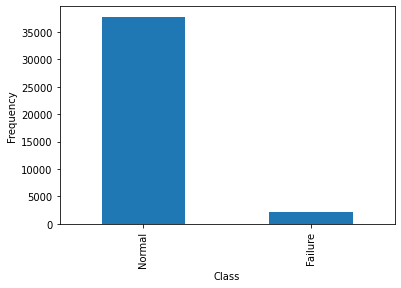

In [14]:
# Check the count of failure cases and normal cases
failure = train[train['Target']==1]
normal = train[train['Target']==0]

# Visualize the count of failure and normal cases
# Graph shows data is highly imbalanced and thus can result in biased results
LABELS = ["Normal", "Failure"]
count_classes = pd.value_counts(train['Target'], sort = True)
count_classes.plot(kind = 'bar')
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [15]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency and dispersion.

def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig 
    bins: number of bins 
    """
    # creating the 2 subplots
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)}, figsize=figsize)
    
    # boxplot will be created and a star will indicate the mean value of the column
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color="violet")  
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins, 
                 palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2)  # For histogram
    ax_hist2.axvline(np.mean(feature), color="green", linestyle="--")  # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color="black", linestyle="-")  # Add median to the histogram

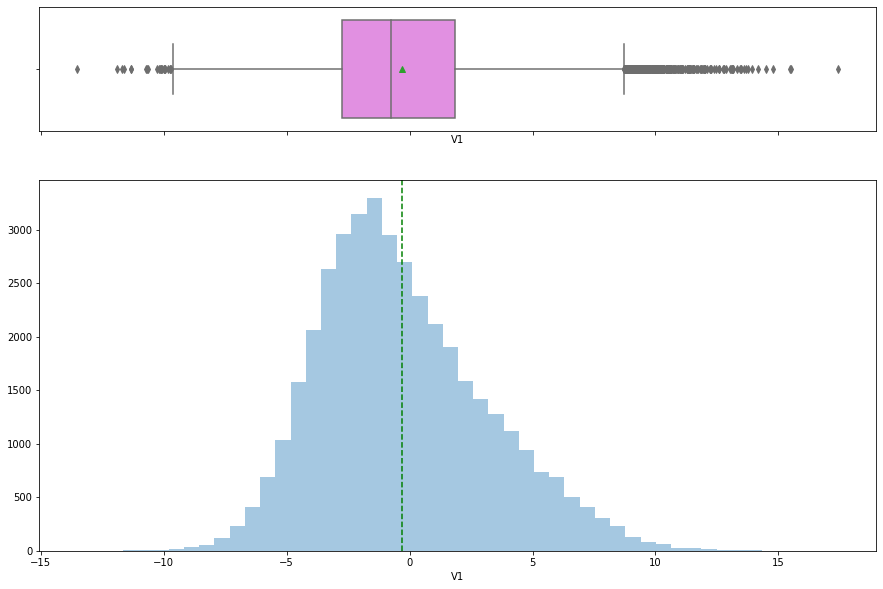

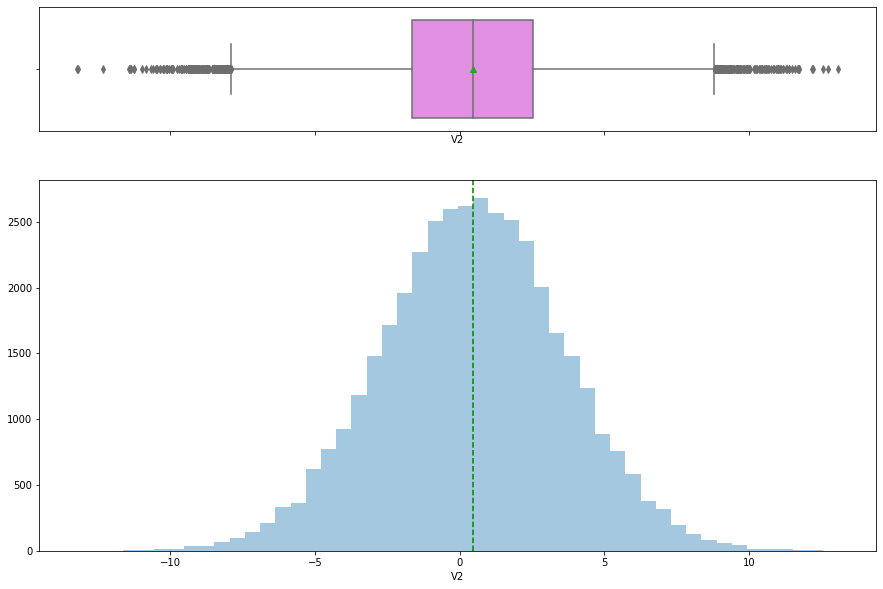

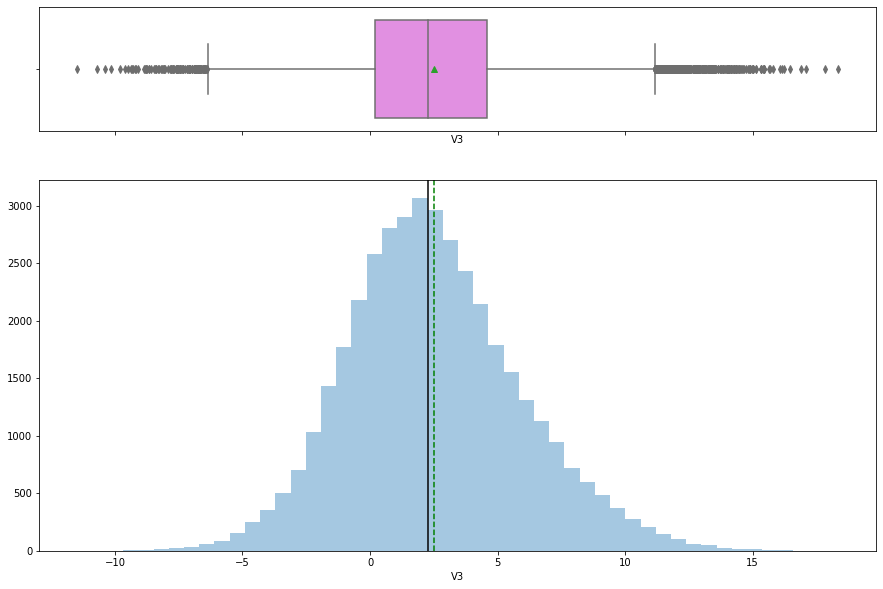

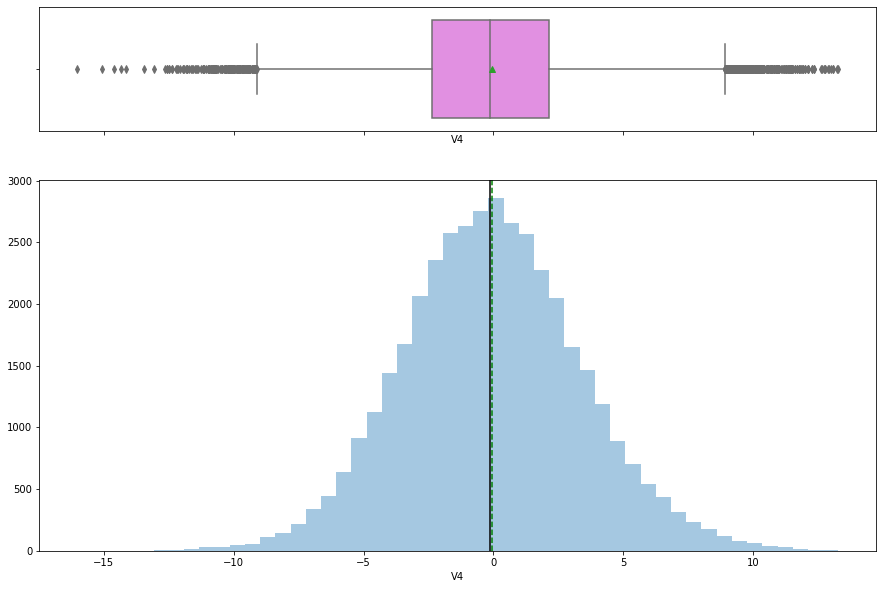

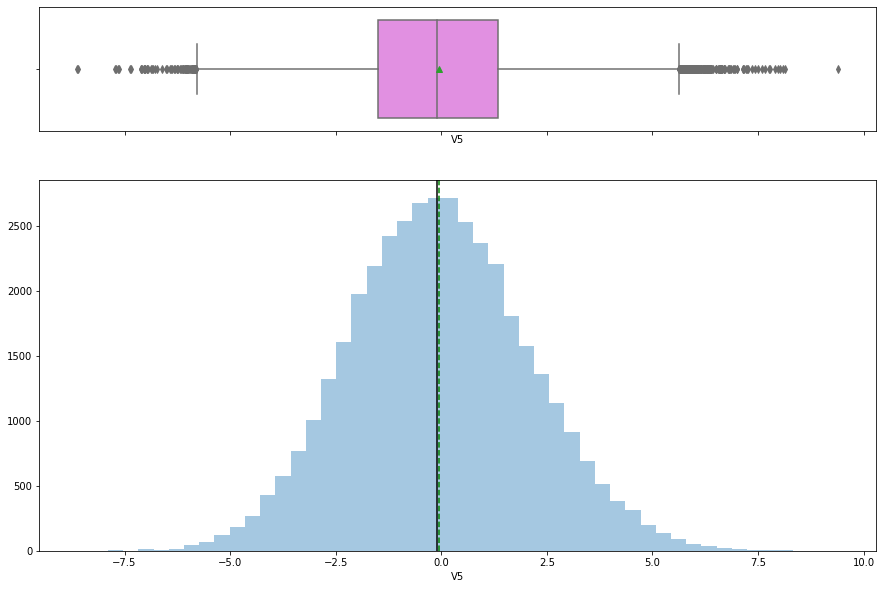

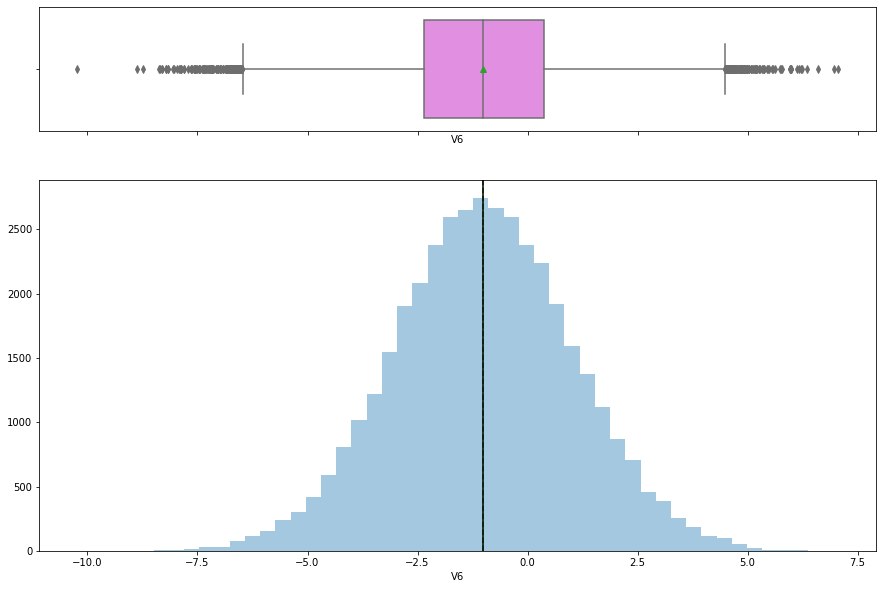

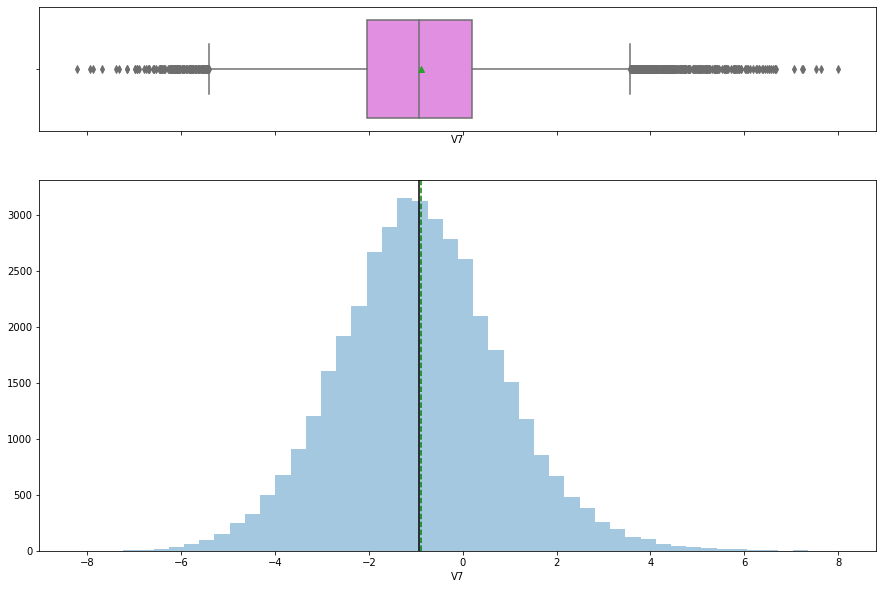

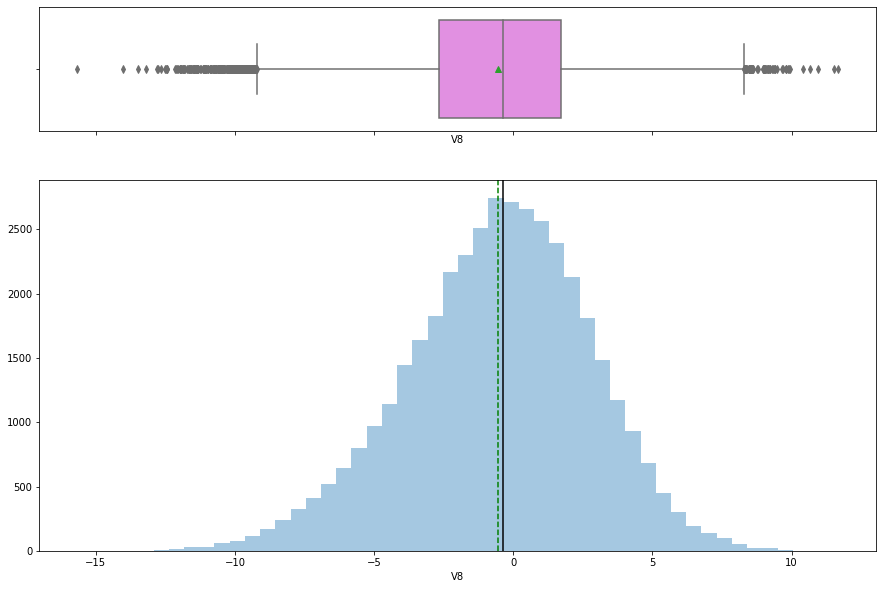

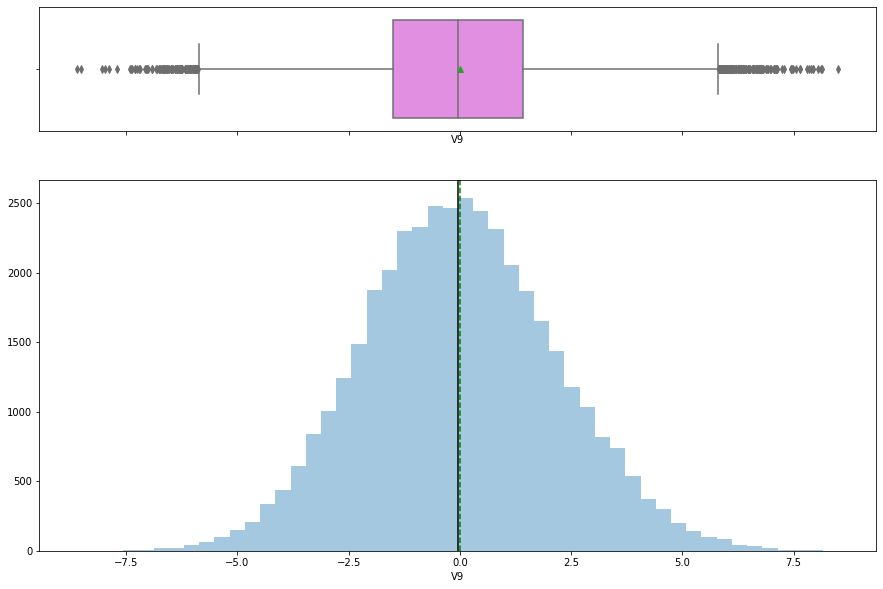

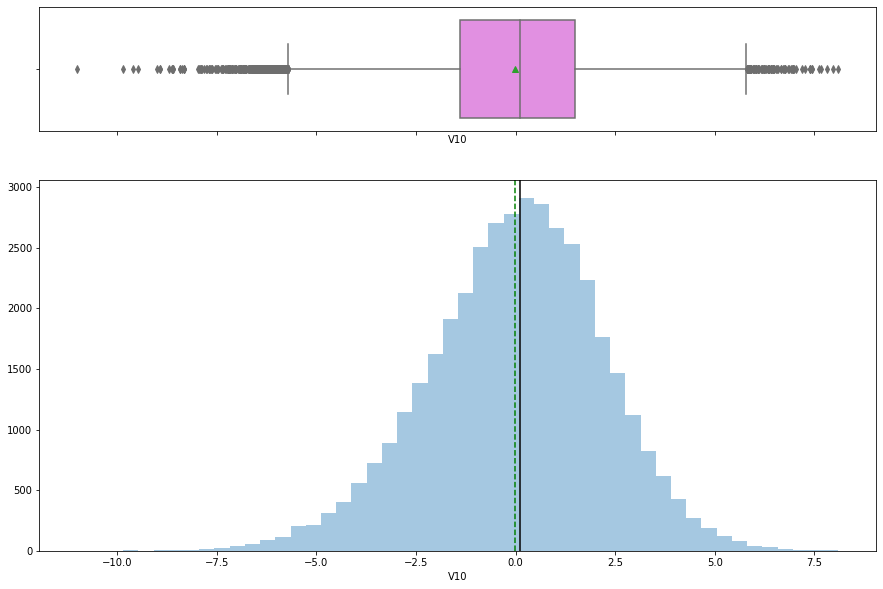

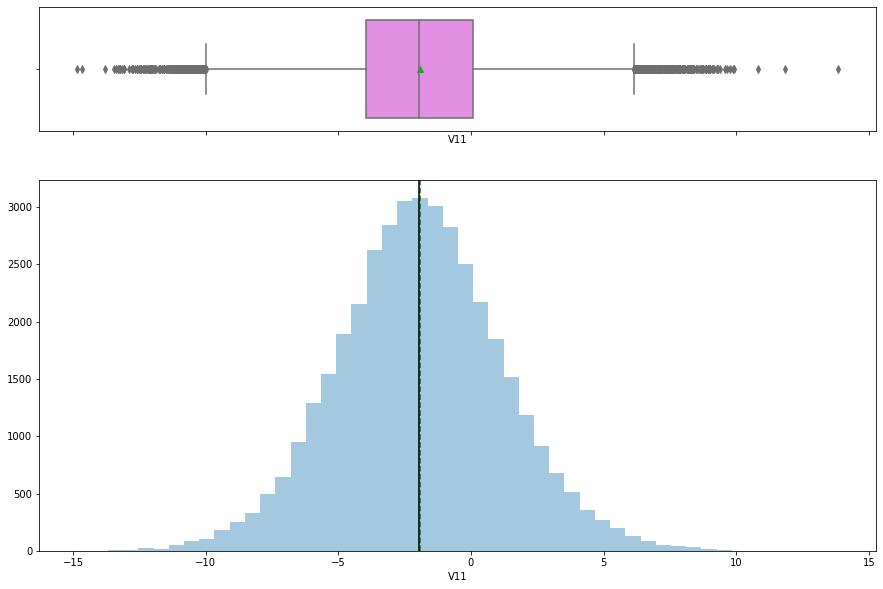

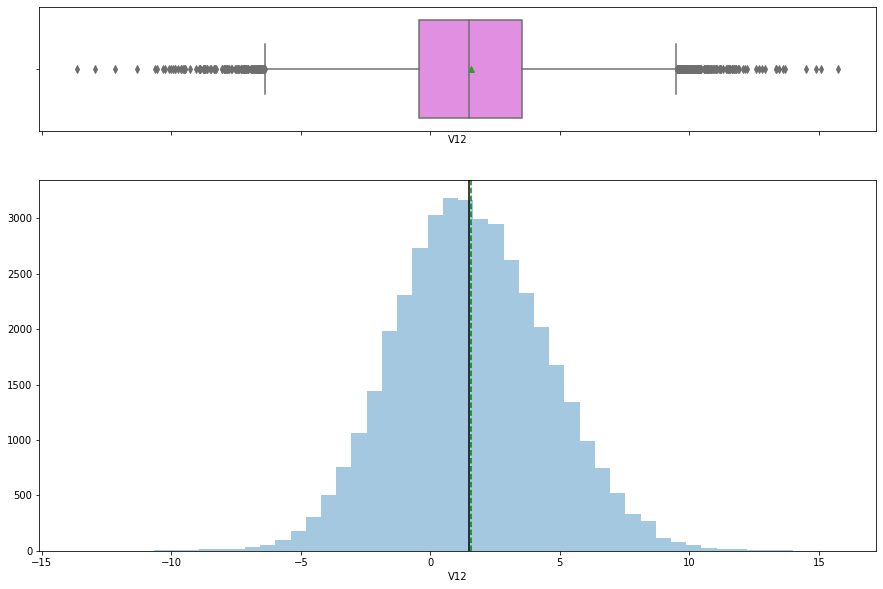

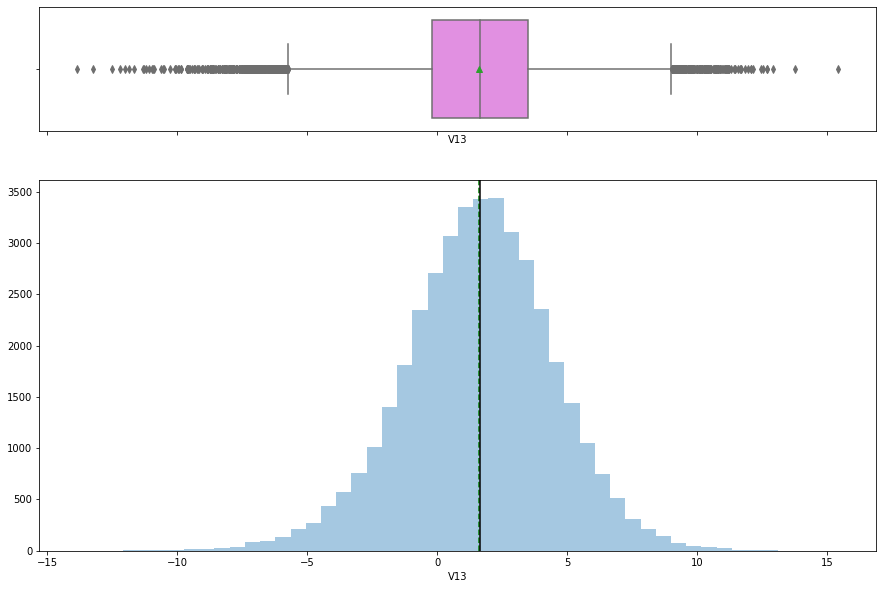

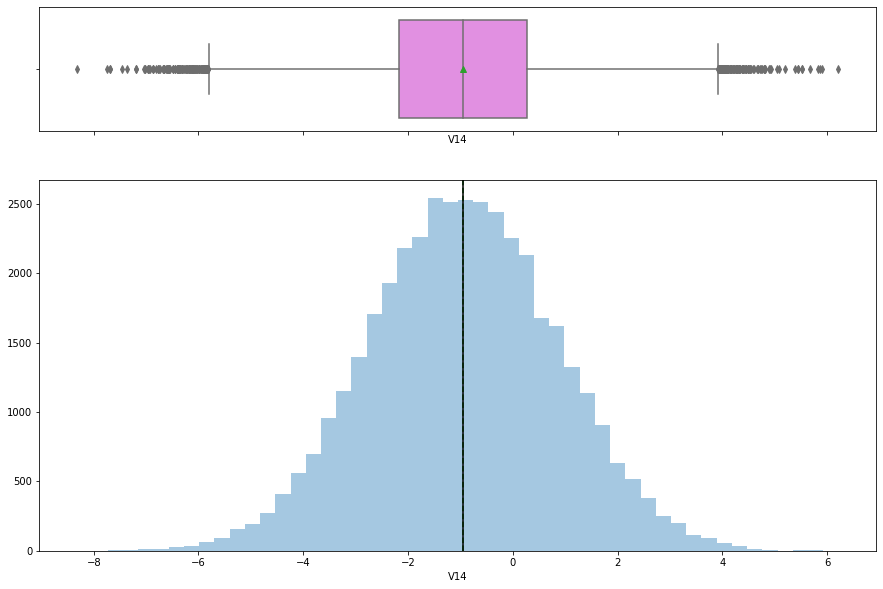

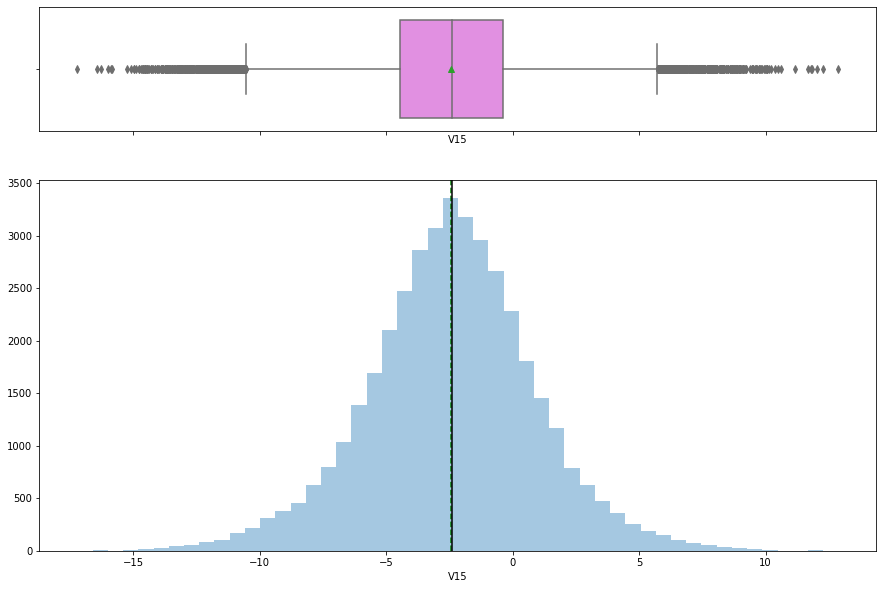

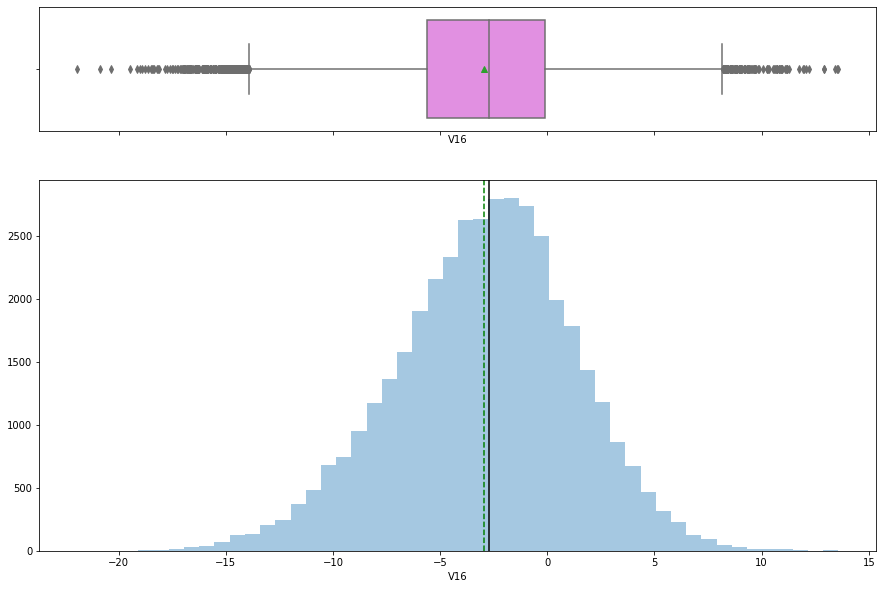

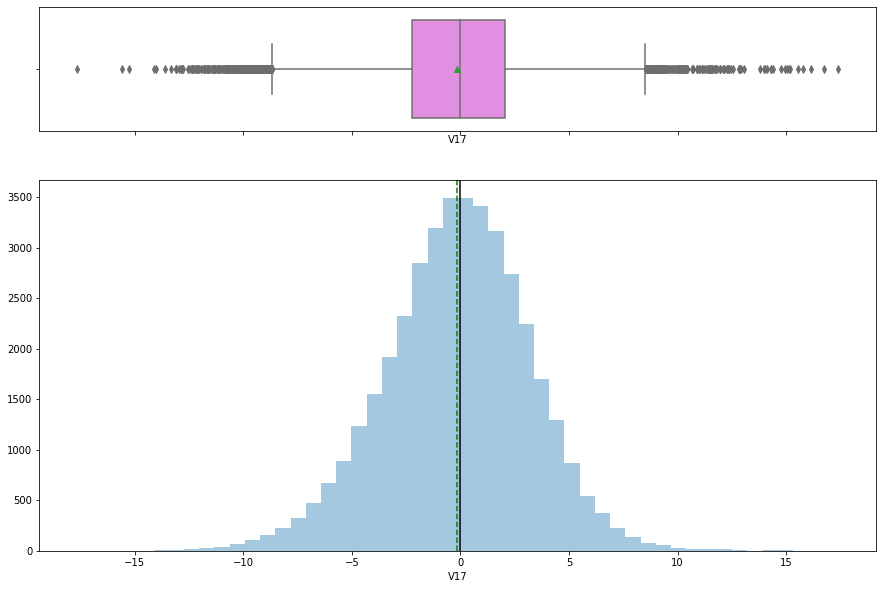

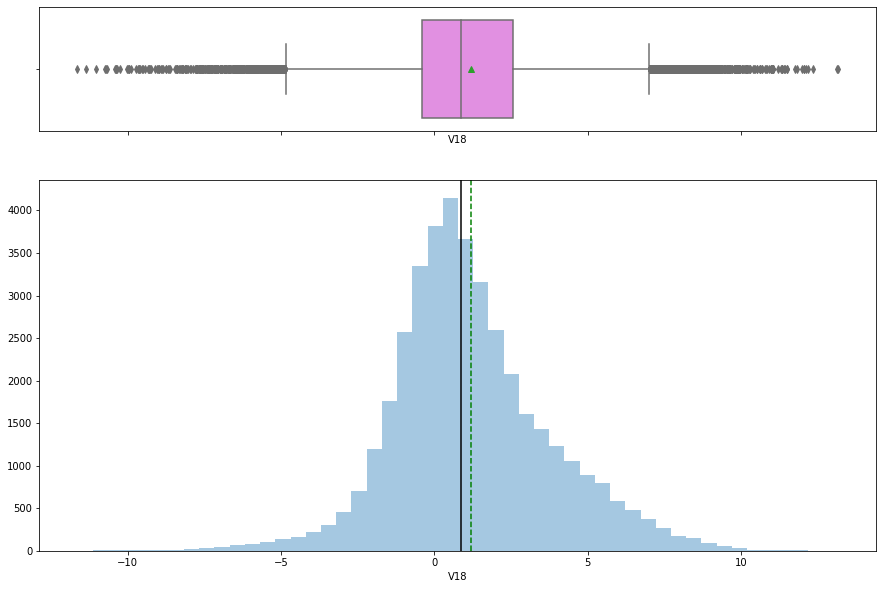

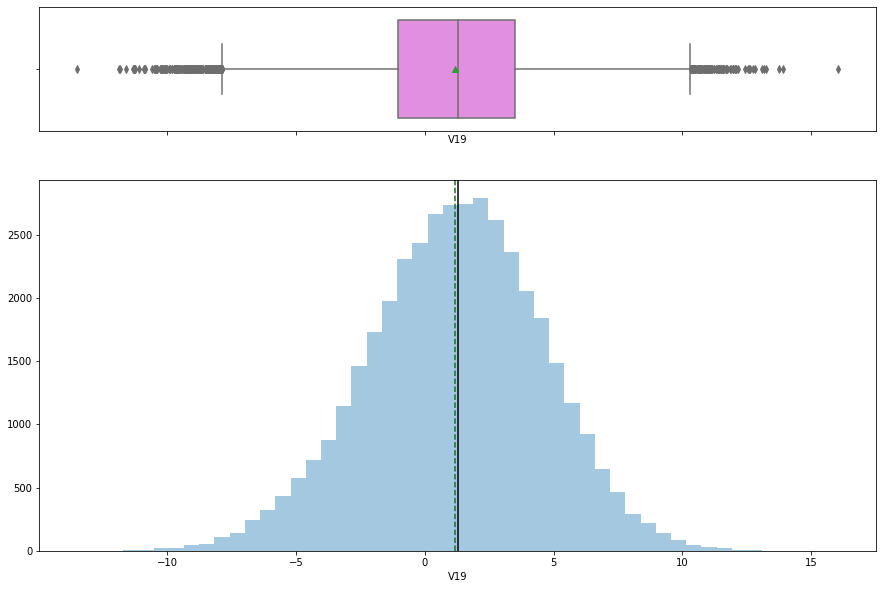

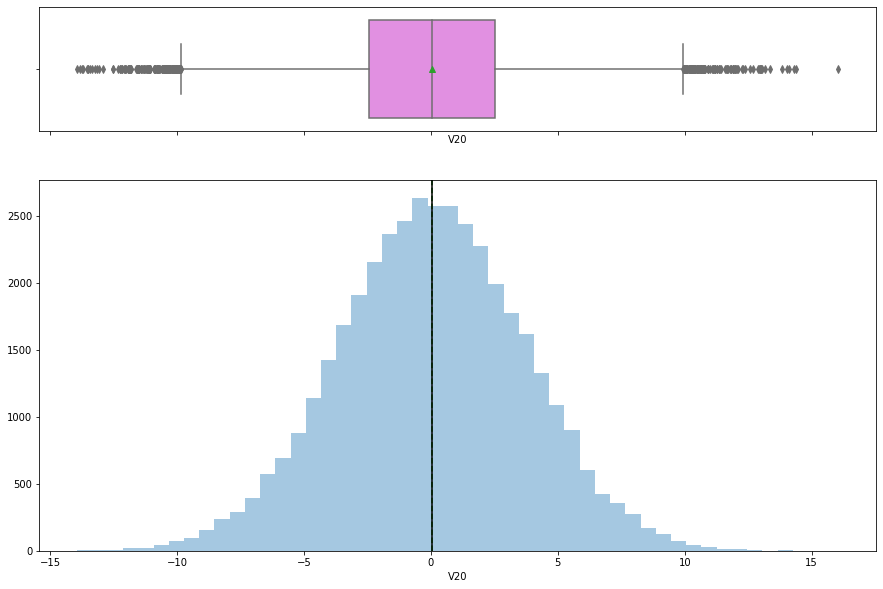

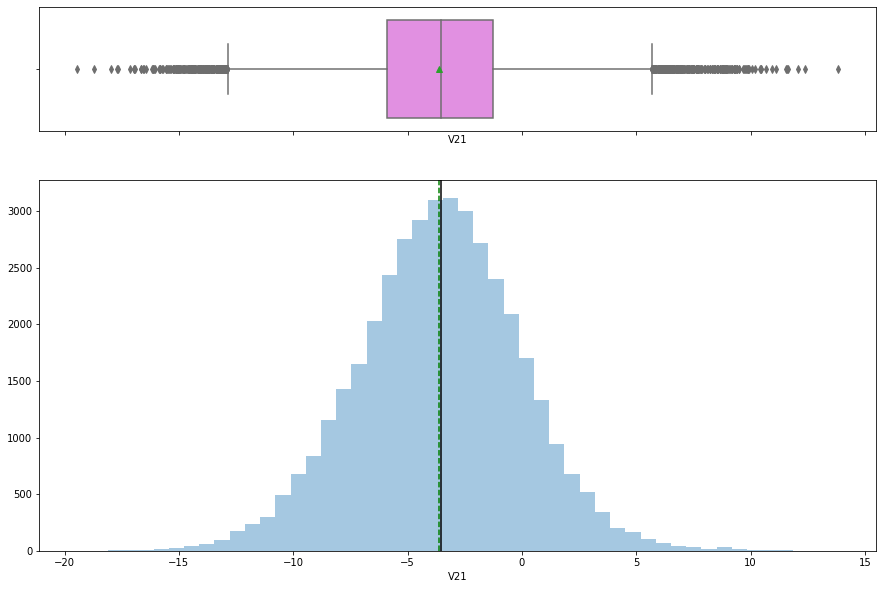

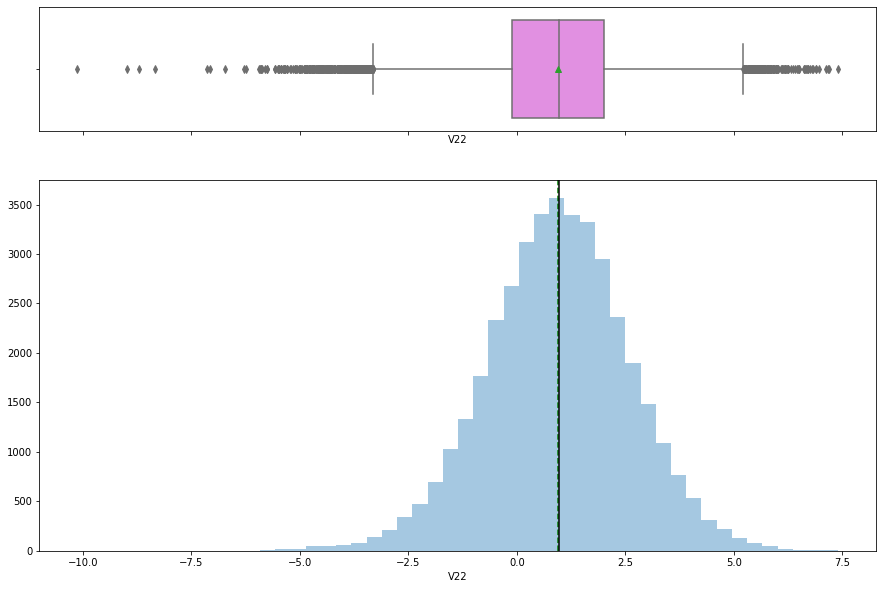

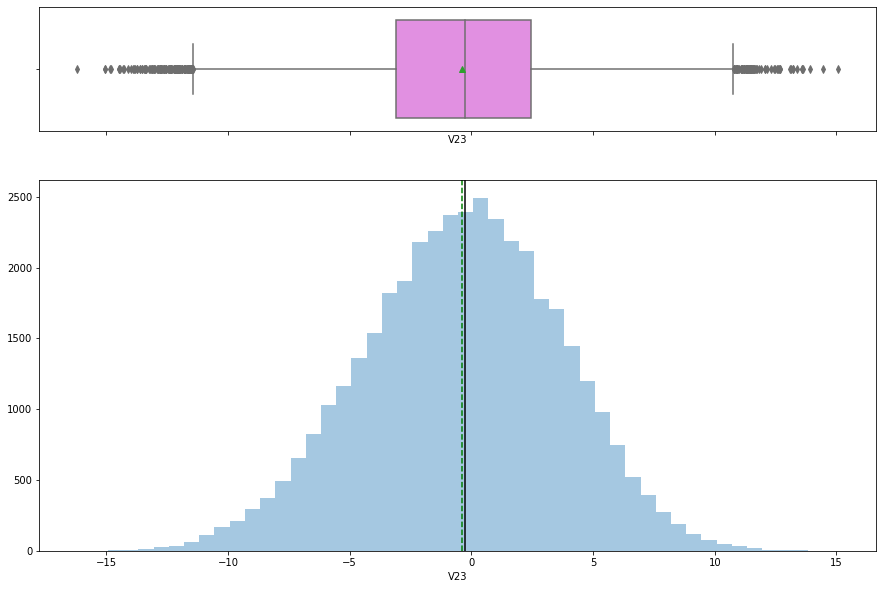

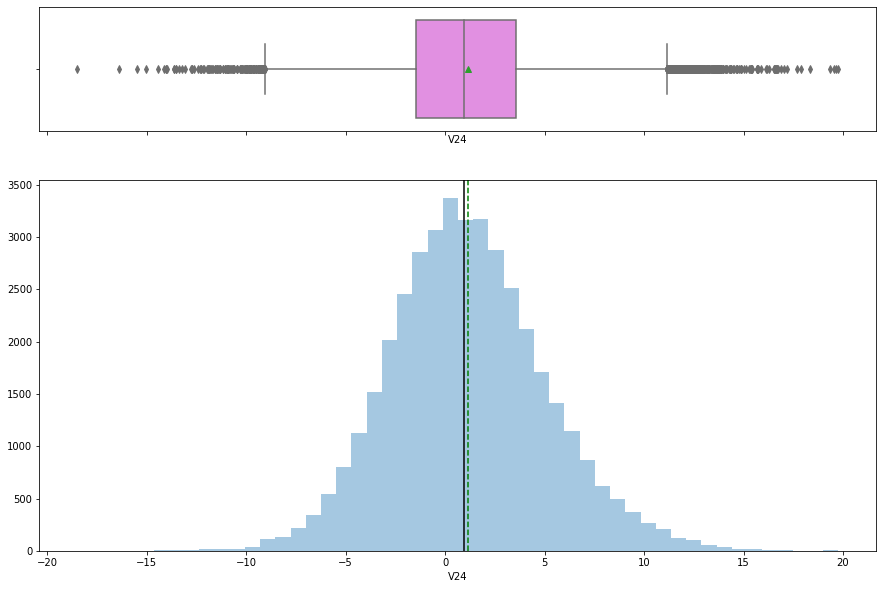

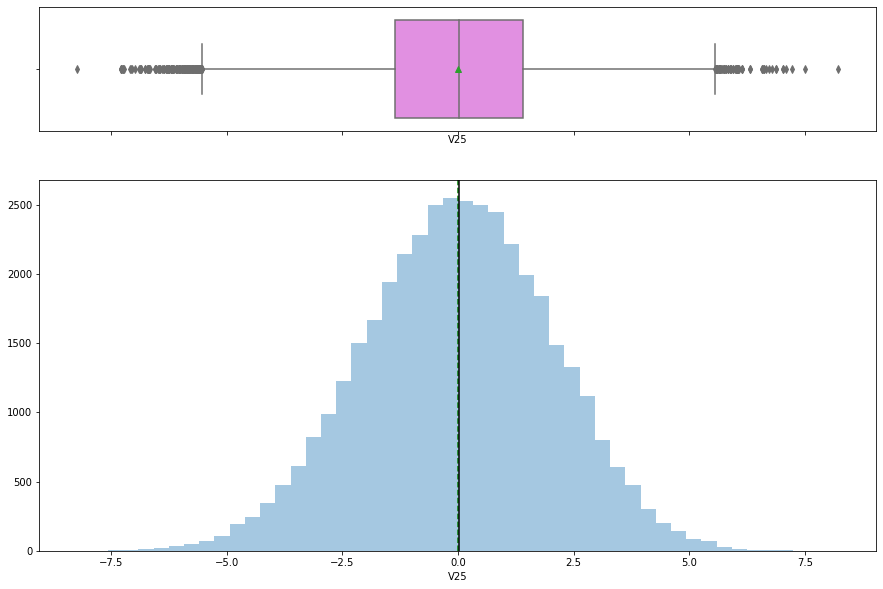

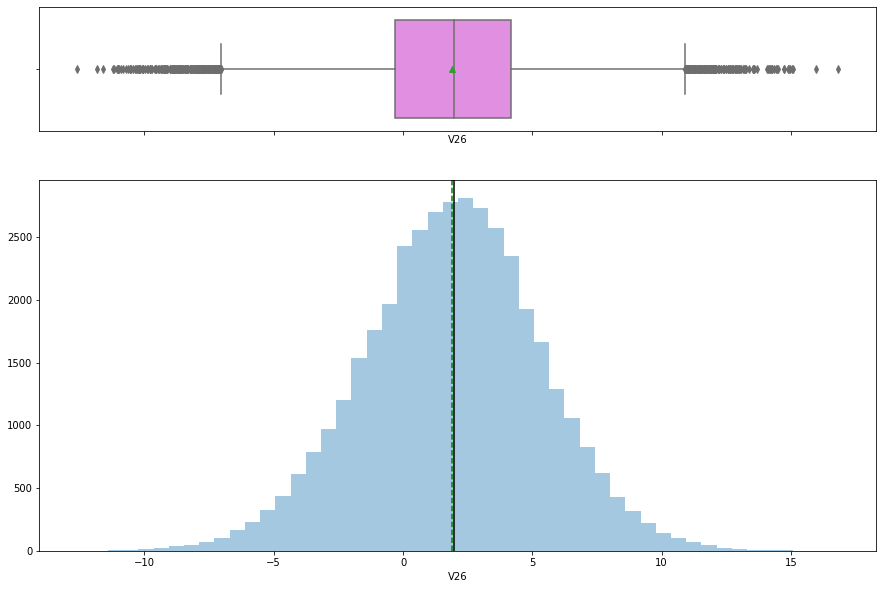

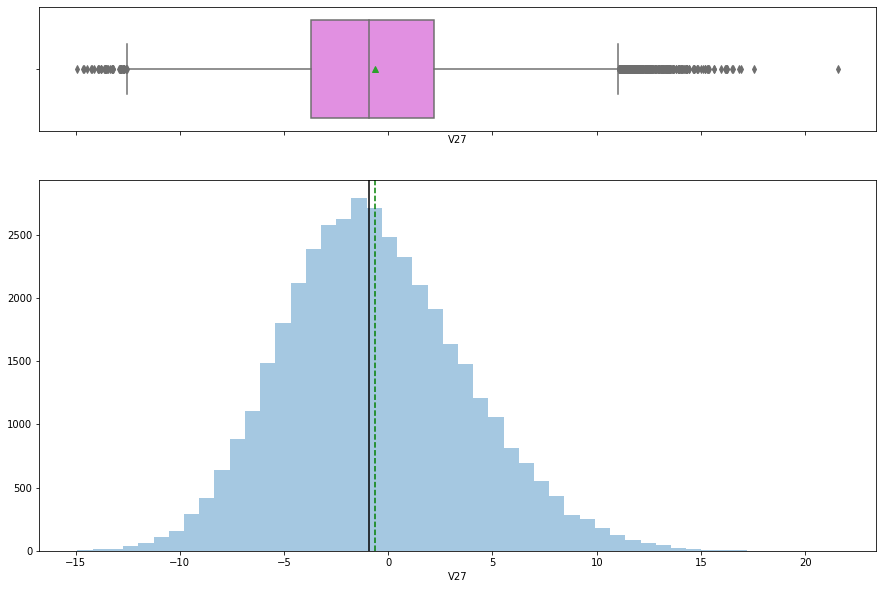

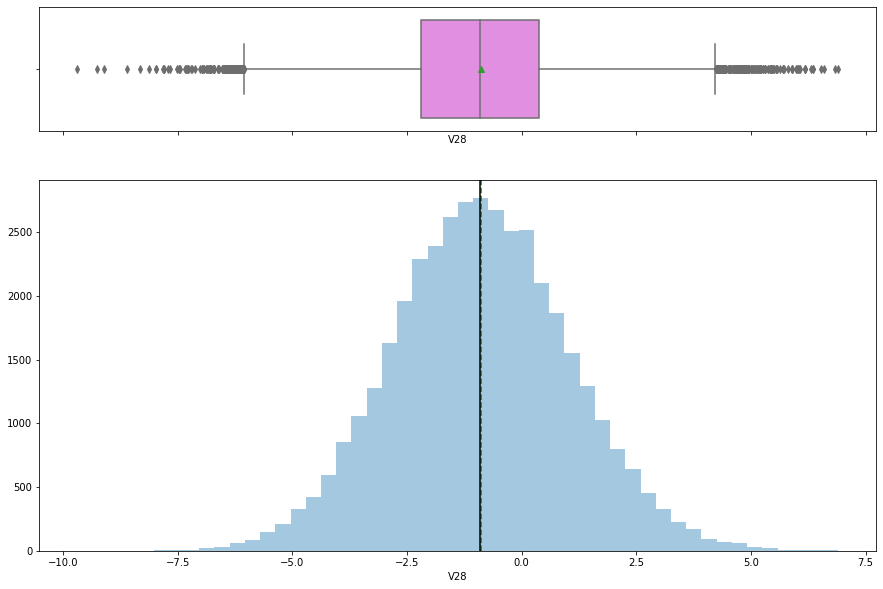

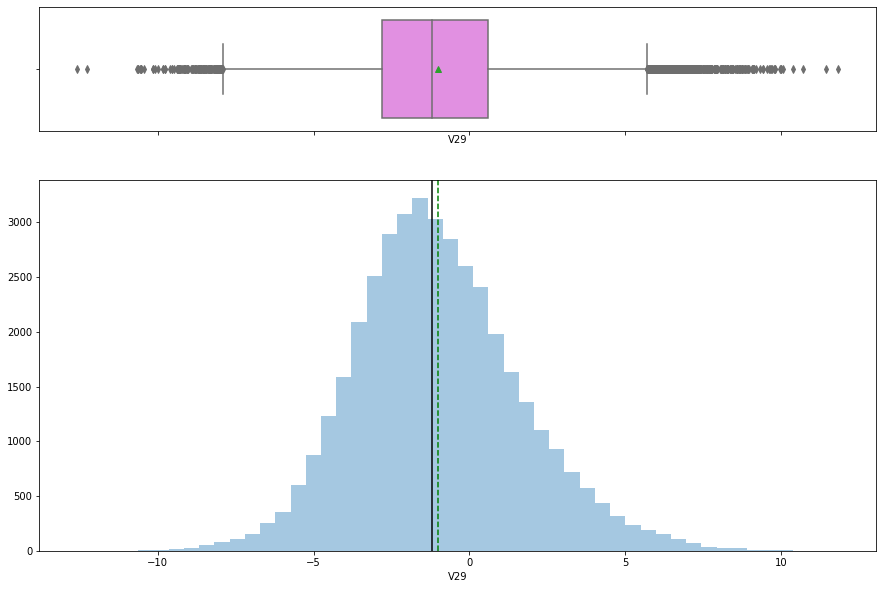

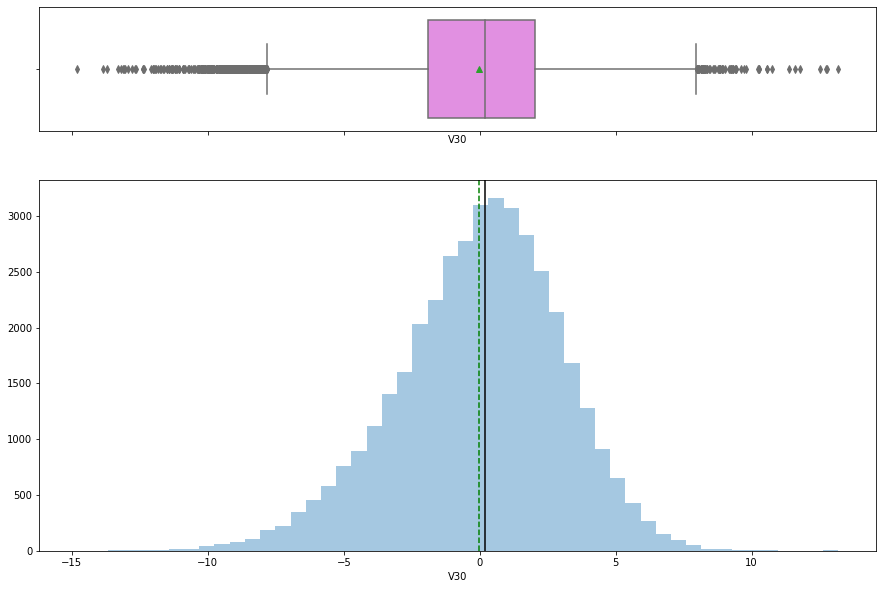

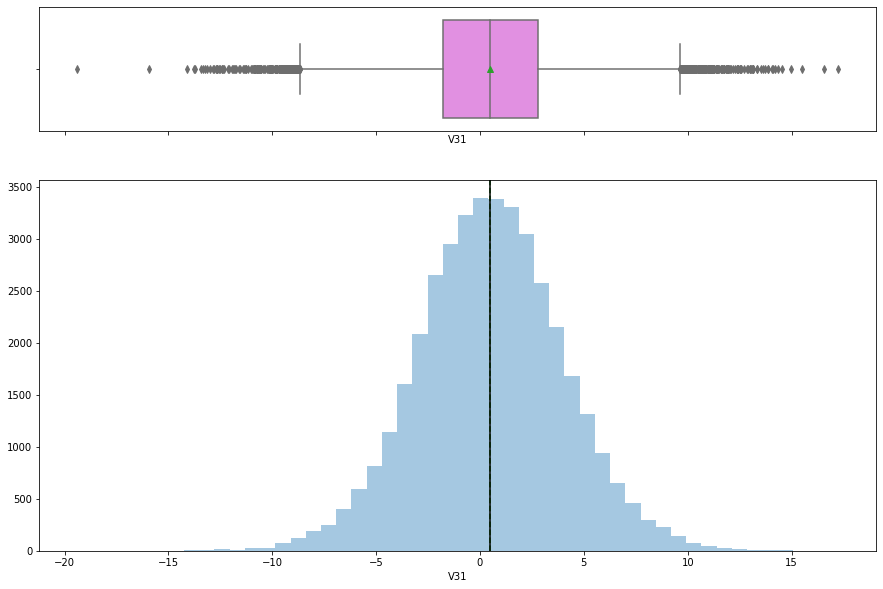

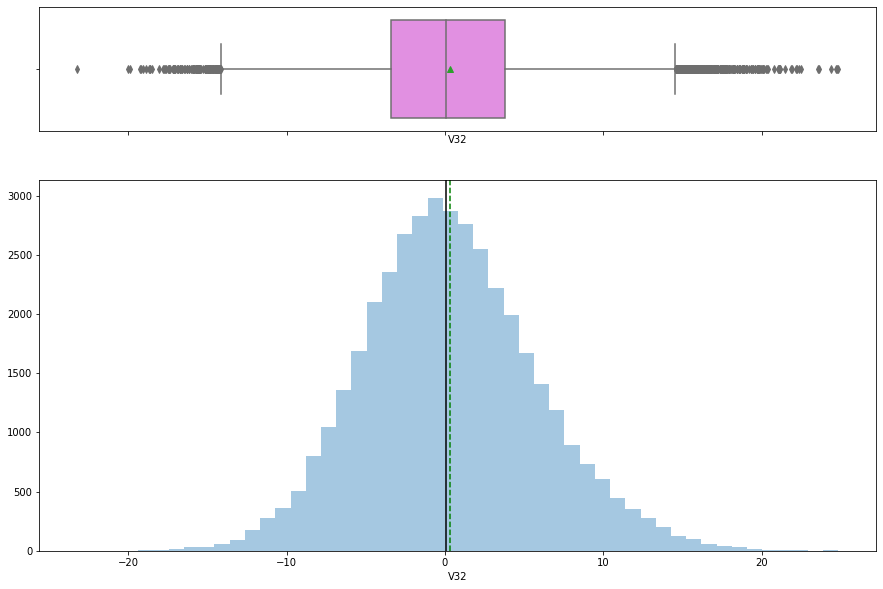

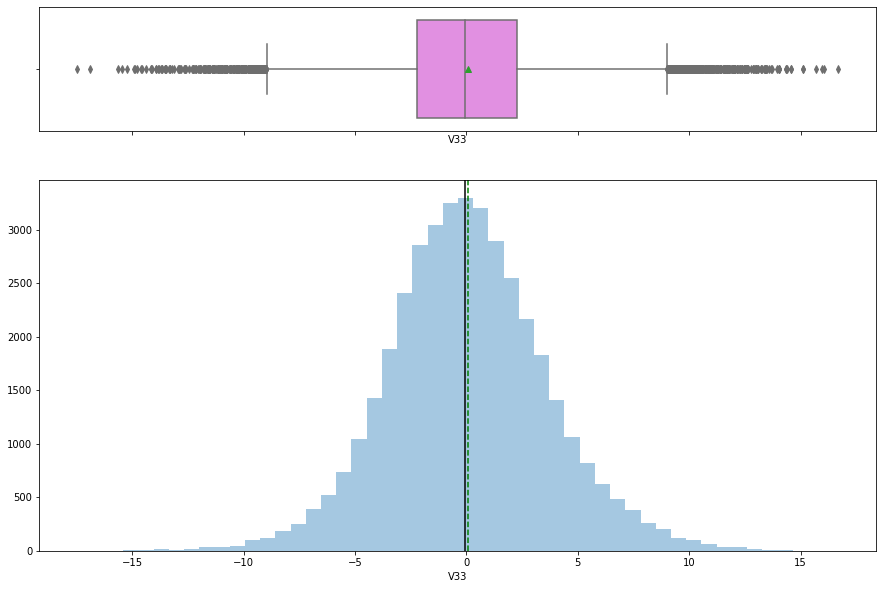

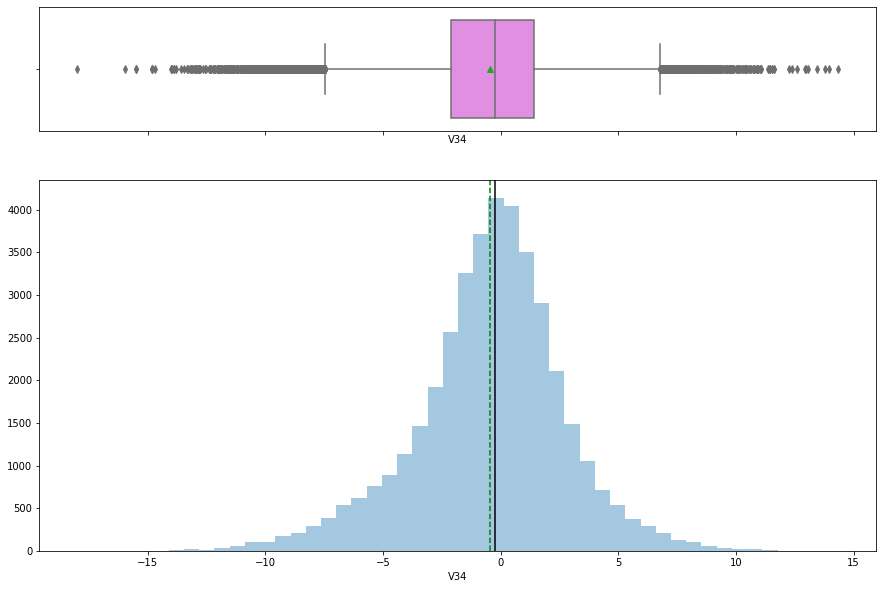

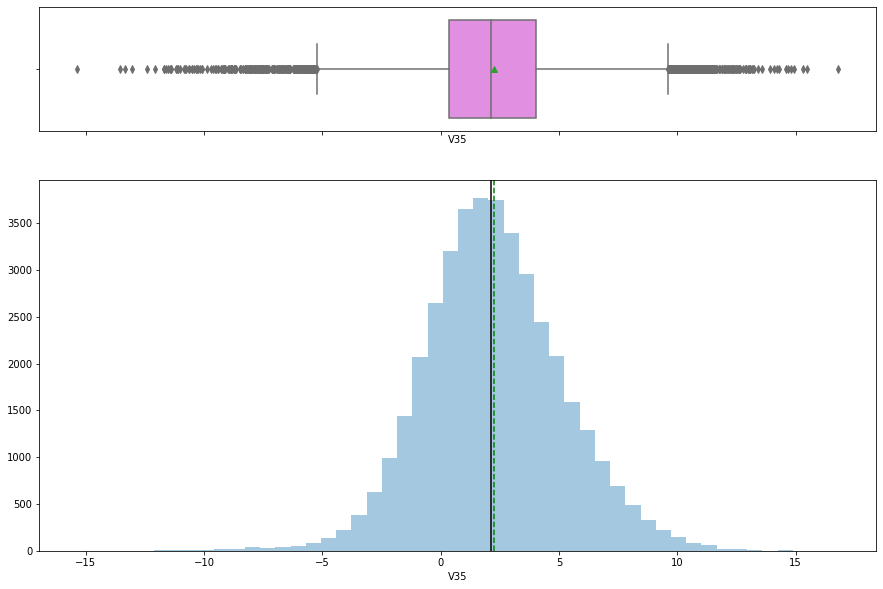

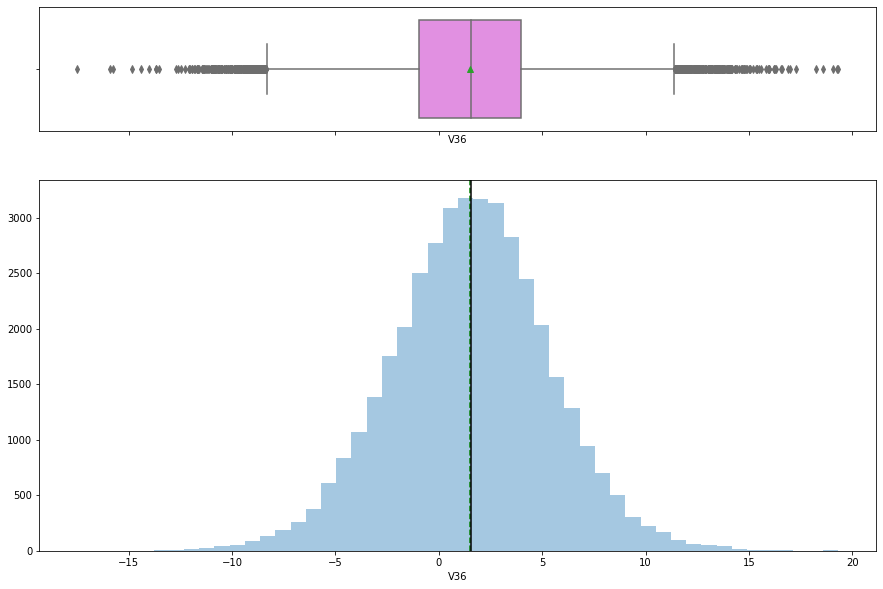

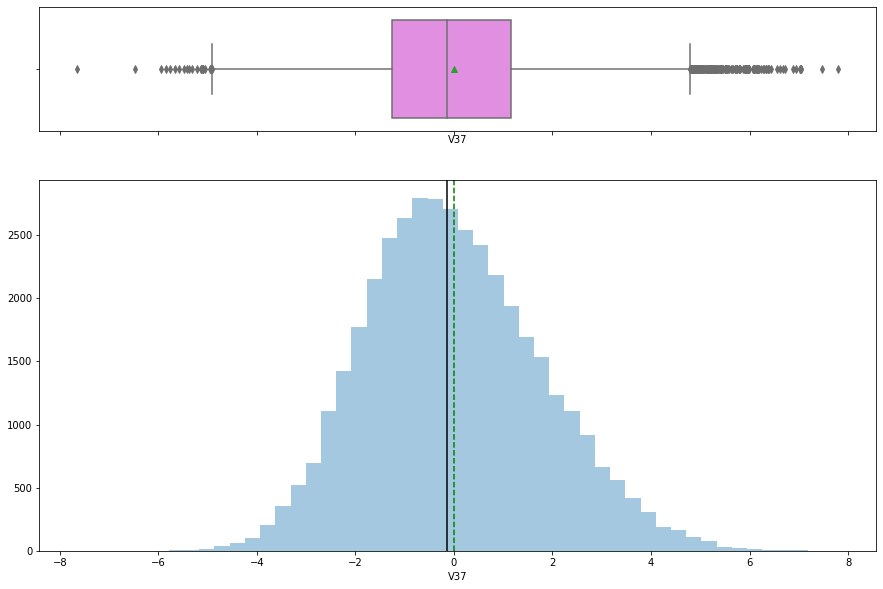

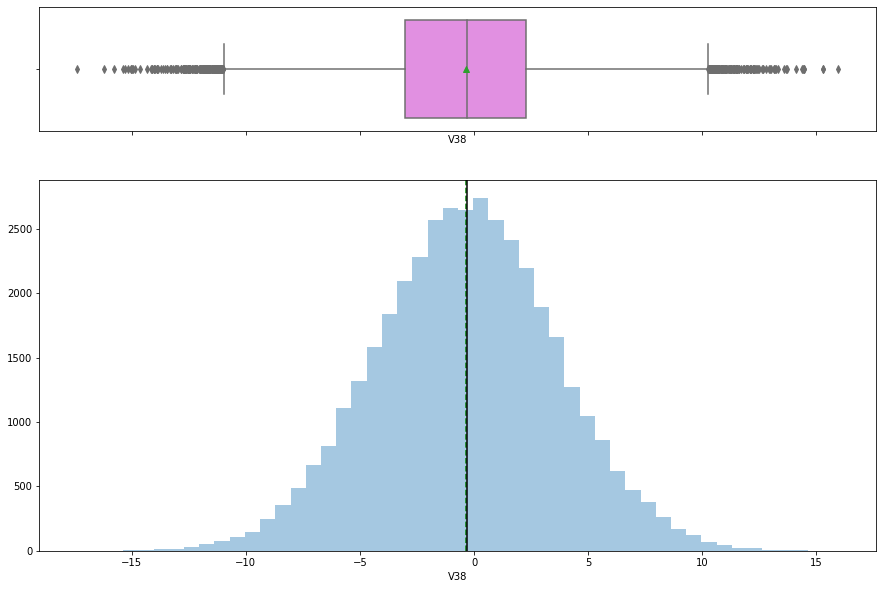

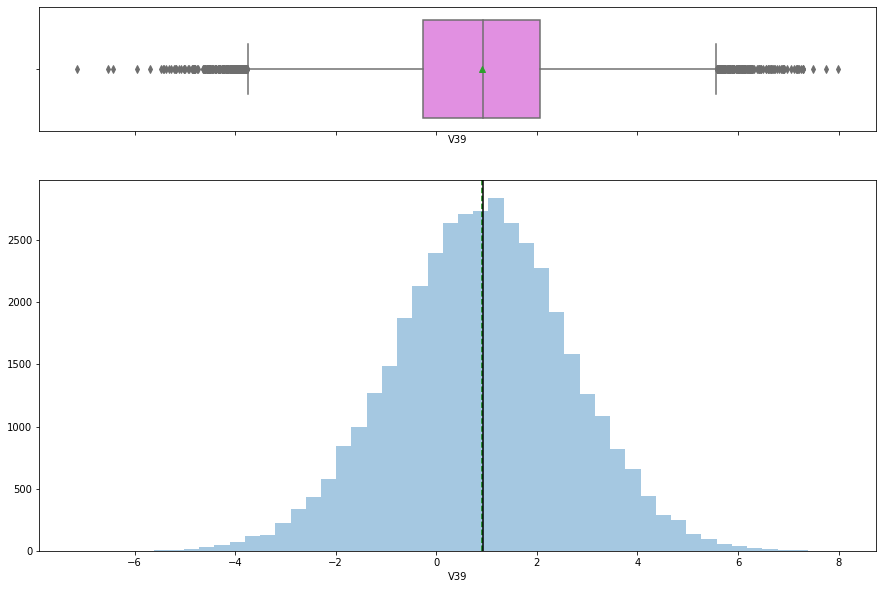

In [16]:
for i in range(1, 40):
    histogram_boxplot(train["V"+str(i)])

In [17]:
# Function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

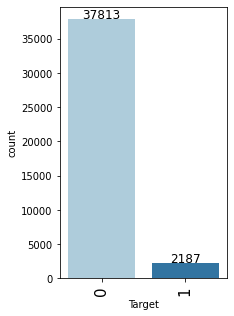

In [18]:
labeled_barplot(train, "Target")

## Data Pre-processing

In [19]:
# As most of the missing values belong to Target class 0, 
# so instead of droping the NA rows, we can assign NA value same as mean value of that feature

train['V1'].fillna((normal['V1'].mean()), inplace=True)
train['V2'].fillna((normal['V2'].mean()), inplace=True)

train.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [20]:
# Filling NA values in test data as well

test['V1'].fillna((normal['V1'].mean()), inplace=True)
test['V2'].fillna((normal['V2'].mean()), inplace=True)

test.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

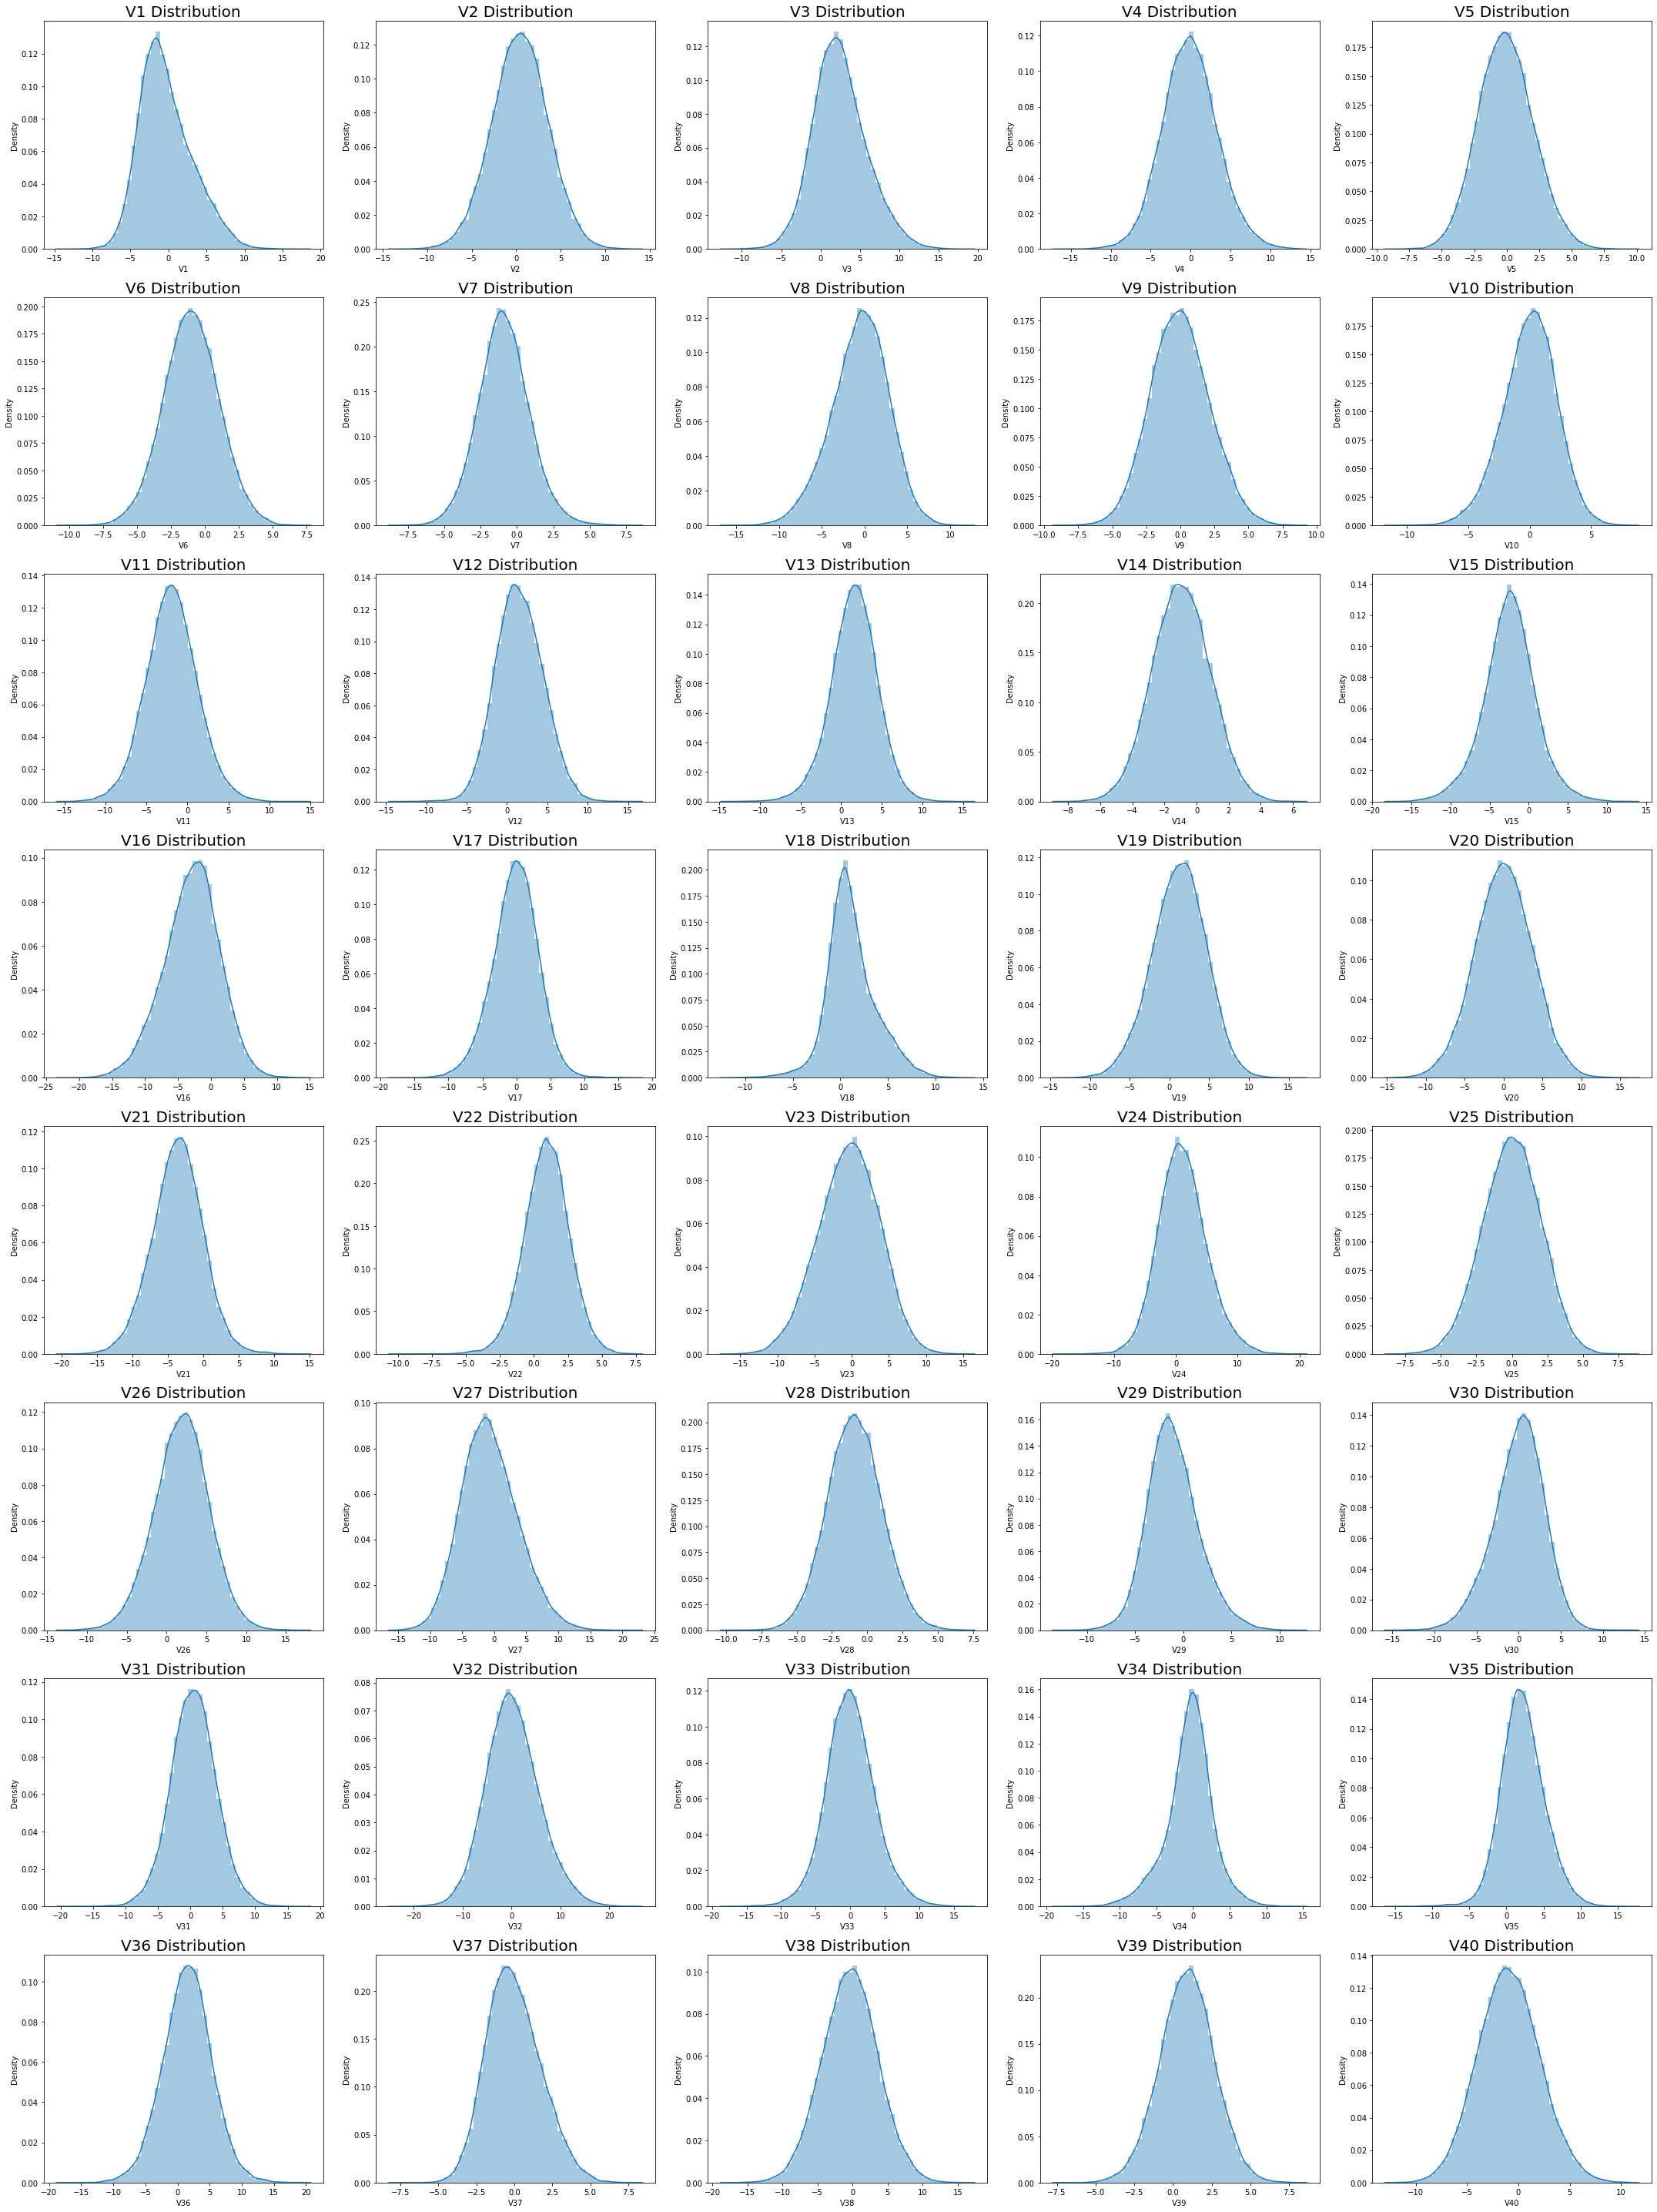

In [21]:
# Check distribution of data
# As all the variables are guassian distributed, with no outliers, so no further processing is required

cols = [features for features in train.columns if features !="Target"]

n_rows, n_cols = len(cols)//5, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))

for r in range(n_rows):
    for c in range(n_cols):
        i = r*n_cols+c
        ax = axs[r][c]
        sns.distplot(train[cols[i]], ax=ax)
        ax.set_title(cols[i] + ' Distribution', fontsize=20)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

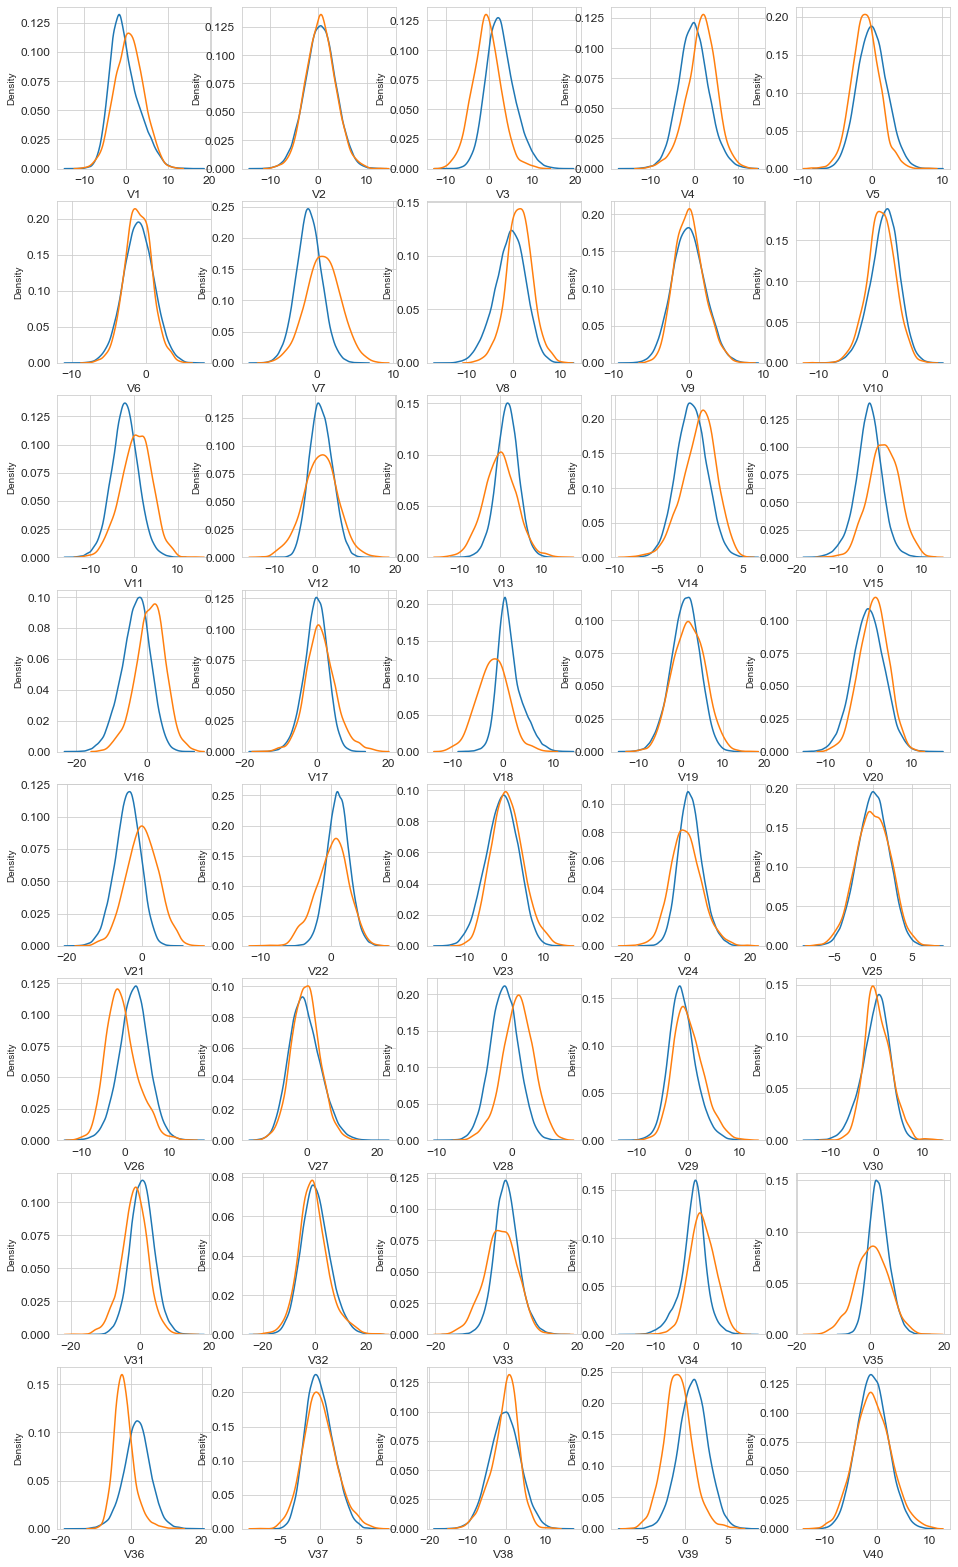

In [22]:
# Kernel density plots highlights the differnce in two classes wrt all variables
# V7, V12, V13, V18, V22, V35 and V36 seems to be the important features in defining the Target varibale 

var = [features for features in train.columns if features !="Target"]

i = 0
t0 = train.loc[train['Target'] == 0]
t1 = train.loc[train['Target'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,5,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,5,i)
    sns.kdeplot(t0[feature], label="Class=0")
    sns.kdeplot(t1[feature], label="Class=1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

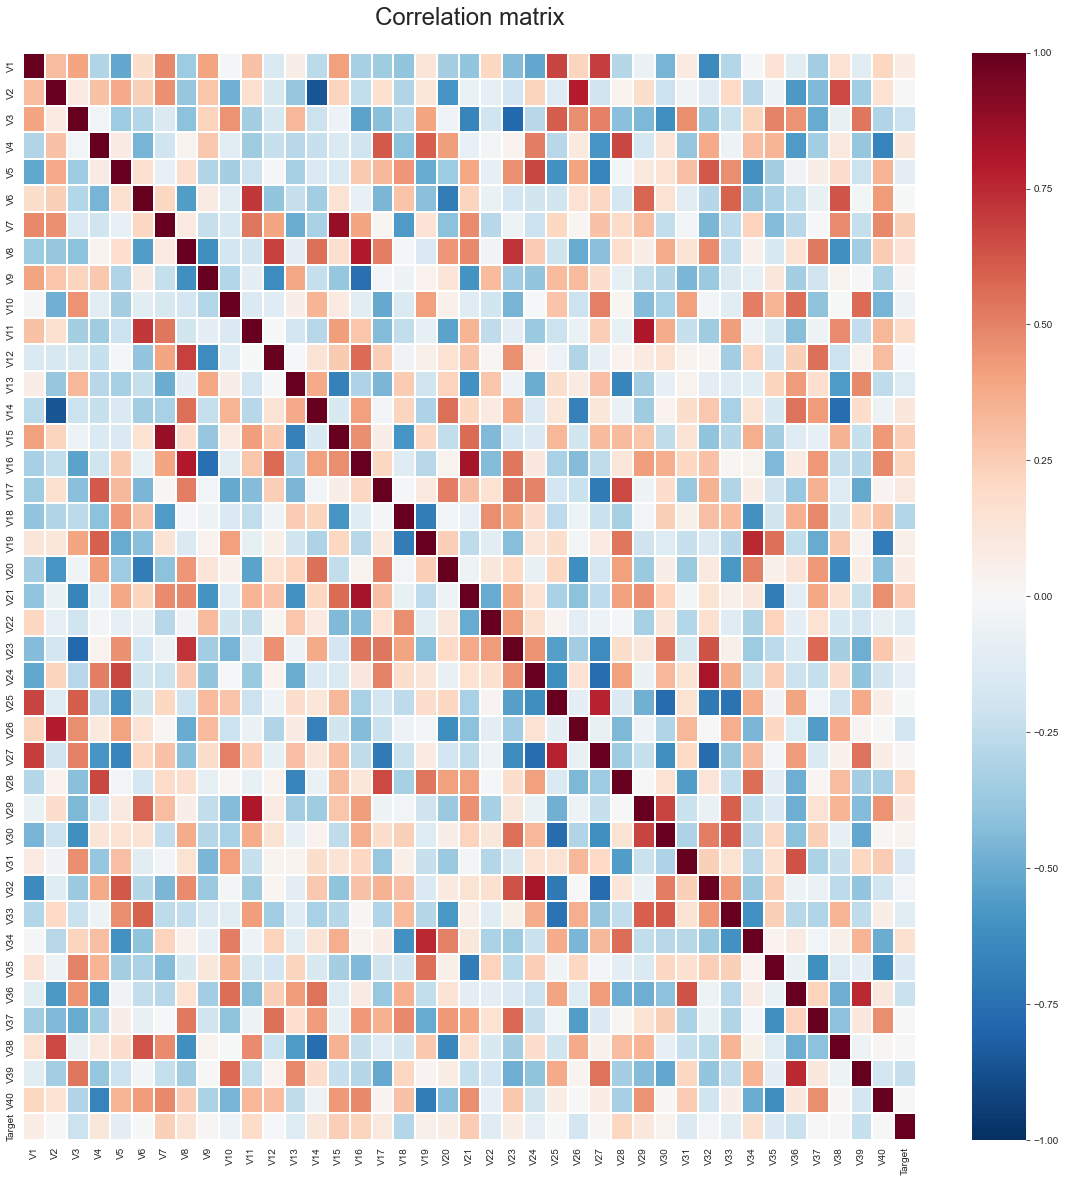

In [23]:
# Correlation matrix again helps in identifying important variables
# Some variables are highly correlated, which is inline with previous kde graphs where both 
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=False, cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidth=2, annot_kws={"fontsize":12},
            square=False, cbar=True).set_title('Correlation matrix', fontsize=24, y=1.02);

## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure 
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost.
* The cost associated with any model = TP * 15000 + FP * 5000 + FN * 40000
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN) * 15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

**Let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [24]:
# Defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (TP + FN) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = Min_Cost / Cost  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

In [25]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Model Building with Original data

In [27]:
# Create dependent and independent features list for train data

columns = [features for features in train.columns if features !="Target"]
target = "Target"
X_train = train[columns]
y_train = train[target]

print(X_train.shape)
print(y_train.shape)

(40000, 40)
(40000,)


In [28]:
# Create dependent and independent features list for test data

columns = [features for features in test.columns if features !="Target"]
target = "Target"
X_test = test[columns]
y_test = test[target]

print(X_test.shape)
print(y_test.shape)

(10000, 40)
(10000,)


In [29]:
# Add KFold cross validation

kfold = KFold(n_splits=5, shuffle = True)

### Logistic Regression

##### Logistic Regression Full Report #####
Error Count : 346
Area Under the Curve: 0.7250662422828538
Confusion Metrics :
[[9405   48]
 [ 298  249]]
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9453
           1       0.84      0.46      0.59       547

    accuracy                           0.97     10000
   macro avg       0.90      0.73      0.79     10000
weighted avg       0.96      0.97      0.96     10000

##### Logistic Regression Original Data Result #####
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9654  0.45521   0.838384  0.590047                 0.5162

##### Cross Validation Result #####
0.9149790434288336


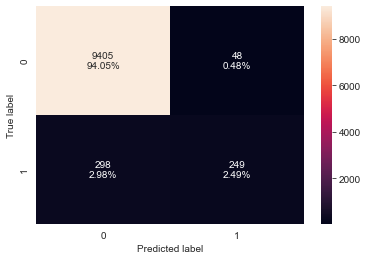

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

n_errors_lr = (y_pred_lr != y_test).sum()
auc_lr = roc_auc_score(y_test, y_pred_lr)

print("##### Logistic Regression Full Report #####")
print("Error Count :", n_errors_lr)
print("Area Under the Curve:", auc_lr)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test, y_pred_lr))
print("Classification Report :")
print(classification_report(y_test, y_pred_lr))

print("##### Logistic Regression Original Data Result #####")
print(model_performance_classification_sklearn(log_reg, X_test, y_test))
confusion_matrix_sklearn(log_reg, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_lr = cross_val_score(log_reg, X_train, y_train, cv=kfold, scoring='roc_auc')
print(cv_result_lr.mean())

### Decision Tree Classifier

##### Decision Tree Classifier Full Report #####
Error Count : 307
Area Under the Curve: 0.8614737087613868
Confusion Metrics :
[[9288  165]
 [ 142  405]]
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9453
           1       0.71      0.74      0.73       547

    accuracy                           0.97     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.97      0.97      0.97     10000

##### Decision Tree Classifier Original Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9693  0.740402   0.710526  0.725157               0.652226

##### Cross Validation Result #####
0.8555092706181331


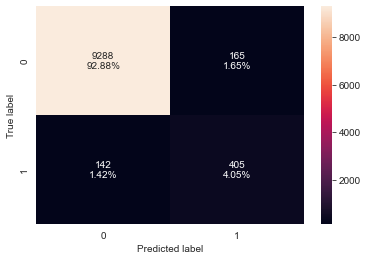

In [31]:
dec_clf = DecisionTreeClassifier()
dec_clf.fit(X_train, y_train)
y_pred_dt = dec_clf.predict(X_test)

n_errors_dt = (y_pred_dt != y_test).sum()
auc_dt = roc_auc_score(y_test, y_pred_dt)

print("##### Decision Tree Classifier Full Report #####")
print("Error Count :", n_errors_dt)
print("Area Under the Curve:", auc_dt)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test, y_pred_dt))
print("Classification Report :")
print(classification_report(y_test, y_pred_dt))

print("##### Decision Tree Classifier Original Data Result #####")
print(model_performance_classification_sklearn(dec_clf, X_test, y_test))
confusion_matrix_sklearn(dec_clf, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_dt = cross_val_score(dec_clf, X_train, y_train, cv=kfold, scoring='roc_auc')
print(cv_result_dt.mean())

### Random Forest Classifier

##### Random Forest Classifier Full Report #####
Error Count : 130
Area Under the Curve: 0.8846147523657406
Confusion Metrics :
[[9449    4]
 [ 126  421]]
Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9453
           1       0.99      0.77      0.87       547

    accuracy                           0.99     10000
   macro avg       0.99      0.88      0.93     10000
weighted avg       0.99      0.99      0.99     10000

##### Random Forest Classifier Original Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0     0.987  0.769653   0.990588  0.866255               0.721319

##### Cross Validation Result #####
0.9528125072839893


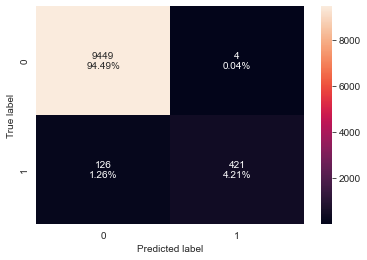

In [32]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

n_errors_rf = (y_pred_rf != y_test).sum()
auc_rf = roc_auc_score(y_test, y_pred_rf)

print("##### Random Forest Classifier Full Report #####")
print("Error Count :", n_errors_rf)
print("Area Under the Curve:", auc_rf)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test, y_pred_rf))
print("Classification Report :")
print(classification_report(y_test, y_pred_rf))

print("##### Random Forest Classifier Original Data Result #####")
print(model_performance_classification_sklearn(rf_model, X_test, y_test))
confusion_matrix_sklearn(rf_model, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_rf = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='roc_auc')
print(cv_result_rf.mean())

### Adaboost Classifier

##### Adaboost Classifier Full Report #####
Error Count : 273
Area Under the Curve: 0.7849043792332739
Confusion Metrics :
[[9413   40]
 [ 233  314]]
Classification Report :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9453
           1       0.89      0.57      0.70       547

    accuracy                           0.97     10000
   macro avg       0.93      0.78      0.84     10000
weighted avg       0.97      0.97      0.97     10000

##### Adaboost Classifier Original Data Result #####
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9727  0.57404   0.887006  0.697003               0.576599

##### Cross Validation Result #####
0.9320703767126994


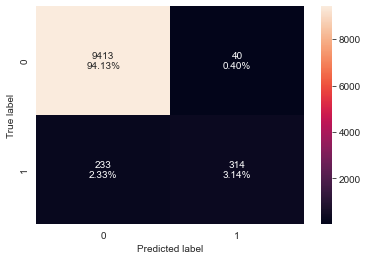

In [33]:
ada_classifier = AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
y_pred_ada = ada_classifier.predict(X_test)

n_errors_ada = (y_pred_ada != y_test).sum()
auc_ada = roc_auc_score(y_test,y_pred_ada)

print("##### Adaboost Classifier Full Report #####")
print("Error Count :",n_errors_ada)
print("Area Under the Curve:", auc_ada)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_ada))
print("Classification Report :")
print(classification_report(y_test,y_pred_ada))

print("##### Adaboost Classifier Original Data Result #####")
print(model_performance_classification_sklearn(ada_classifier, X_test, y_test))
confusion_matrix_sklearn(ada_classifier, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_ab = cross_val_score(ada_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(cv_result_ab.mean())

### KNN Classifier

##### KNN Classifier Full Report #####
Error Count : 128
Area Under the Curve: 0.8855817224095888
Confusion Metrics :
[[9450    3]
 [ 125  422]]
Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9453
           1       0.99      0.77      0.87       547

    accuracy                           0.99     10000
   macro avg       0.99      0.89      0.93     10000
weighted avg       0.99      0.99      0.99     10000

##### KNN Classifier Original Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9872  0.771481   0.992941  0.868313               0.723226

##### Cross Validation Result #####
0.9322850250191516


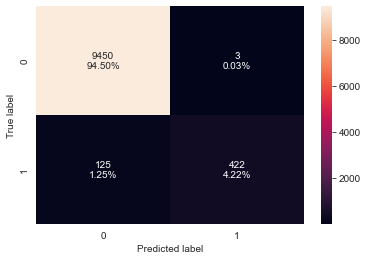

In [34]:
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

n_errors_knn = (y_pred_knn != y_test).sum()
auc_knn = roc_auc_score(y_test,y_pred_knn)

print("##### KNN Classifier Full Report #####")
print("Error Count :",n_errors_knn)
print("Area Under the Curve:", auc_knn)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test,y_pred_knn))
print("Classification Report :")
print(classification_report(y_test,y_pred_knn))

print("##### KNN Classifier Original Data Result #####")
print(model_performance_classification_sklearn(knn_classifier, X_test, y_test))
confusion_matrix_sklearn(knn_classifier, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_knn = cross_val_score(knn_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(cv_result_knn.mean())

### XGBoost Classifier

[18:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
##### XGBoost Classifier Full Report #####
Error Count : 103
Area Under the Curve: 0.9136007430971393
Confusion Metrics :
[[9444    9]
 [  94  453]]
Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9453
           1       0.98      0.83      0.90       547

    accuracy                           0.99     10000
   macro avg       0.99      0.91      0.95     10000
weighted avg       0.99      0.99      0.99     10000

##### XGBoost Classifier Original Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9897  0.828154   0.980519  0.897919               0.774057

#####

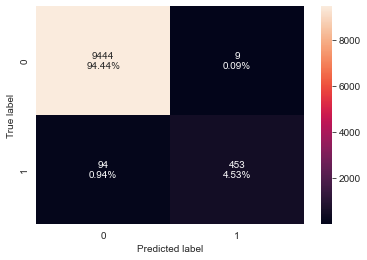

In [35]:
xgb_classifier=xgboost.XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

n_errors_xgb = (y_pred_xgb != y_test).sum()
auc_xgb = roc_auc_score(y_test,y_pred_xgb)

print("##### XGBoost Classifier Full Report #####")
print("Error Count :", n_errors_xgb)
print("Area Under the Curve:", auc_xgb)
print("Confusion Metrics :")
print(metrics.confusion_matrix(y_test, y_pred_xgb))
print("Classification Report :")
print(classification_report(y_test, y_pred_xgb))

print("##### XGBoost Classifier Original Data Result #####")
print(model_performance_classification_sklearn(xgb_classifier, X_test, y_test))
confusion_matrix_sklearn(xgb_classifier, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=kfold, scoring='roc_auc')
print(cv_result_xgb.mean())

#### Result

In [36]:
print("## Testing with Original Data ##\n")
print("Cross-Validation Performance:")
print("Logistic Regression: ", cv_result_lr.mean())
print("Decision Tree: ", cv_result_dt.mean())
print("Random Forest: ", cv_result_rf.mean())
print("AdaBoost Classifier: ", cv_result_ab.mean())
print("KNN Classifier: ", cv_result_knn.mean())
print("XGBoost Classifier: ", cv_result_xgb.mean())

print("\n \nTraining Performance:")
print("Logistic Regression: ", Minimum_Vs_Model_cost(log_reg, X_test, y_test))
print("Decision Tree: ", Minimum_Vs_Model_cost(dec_clf, X_test, y_test))
print("Random Forest: ", Minimum_Vs_Model_cost(rf_model, X_test, y_test))
print("AdaBoost Classifier: ", Minimum_Vs_Model_cost(ada_classifier, X_test, y_test))
print("KNN Classifier: ", Minimum_Vs_Model_cost(knn_classifier, X_test, y_test))
print("XGBoost Classifier: ", Minimum_Vs_Model_cost(xgb_classifier, X_test, y_test))

## Testing with Original Data ##

Cross-Validation Performance:
Logistic Regression:  0.9149790434288336
Decision Tree:  0.8555092706181331
Random Forest:  0.9528125072839893
AdaBoost Classifier:  0.9320703767126994
KNN Classifier:  0.9322850250191516
XGBoost Classifier:  0.954246903285679

 
Training Performance:
Logistic Regression:  0.5162000629128657
Decision Tree:  0.6522257551669316
Random Forest:  0.7213186813186813
AdaBoost Classifier:  0.5765987350667604
KNN Classifier:  0.7232260907888938
XGBoost Classifier:  0.7740566037735849


## Model Building with Oversampled data


In [37]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [38]:
print("Original Data Size")
print(X_train.shape)
print(y_train.shape)
print("Oversampled Data Size")
print(X_train_over.shape)
print(y_train_over.shape)

Original Data Size
(40000, 40)
(40000,)
Oversampled Data Size
(75626, 40)
(75626,)


### Logistic Regression

##### Logistic Regression Oversampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.8692  0.828154   0.271746  0.409214               0.493534

##### Cross Validation Result #####
[0.92944786 0.92580232]


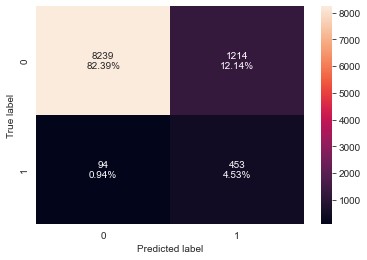

In [39]:
log_reg.fit(X_train_over, y_train_over)
y_pred_lr = log_reg.predict(X_test)

print("##### Logistic Regression Oversampled Data Result #####")
print(model_performance_classification_sklearn(log_reg, X_test, y_test))
confusion_matrix_sklearn(log_reg, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_lro = cross_val_score(log_reg, X_train_over, y_train_over, cv=kfold, scoring='roc_auc')
print(cv_result_lro)

### Decision Tree Classifier

##### Decision Tree Classifier Oversampled Data Result #####
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9506  0.78245   0.533001  0.634074               0.628495

##### Cross Validation Result #####
[0.95099653 0.95173514]


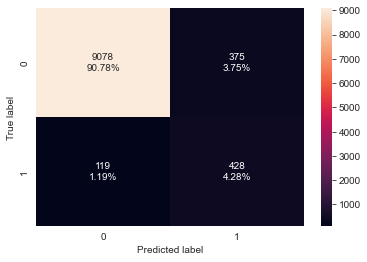

In [40]:
dec_clf.fit(X_train_over, y_train_over)
y_pred_dt = dec_clf.predict(X_test)

print("##### Decision Tree Classifier Oversampled Data Result #####")
print(model_performance_classification_sklearn(dec_clf, X_test, y_test))
confusion_matrix_sklearn(dec_clf, X_test, y_test)


print("\n##### Cross Validation Result #####")
cv_result_dto = cross_val_score(dec_clf, X_train_over, y_train_over, cv=kfold, scoring='roc_auc')
print(cv_result_dto)

### Random Forest Classifier

##### Random Forest Classifier Oversampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9894  0.848263   0.952772  0.897485               0.789322

##### Cross Validation Result #####
[0.99842512 0.9986001 ]


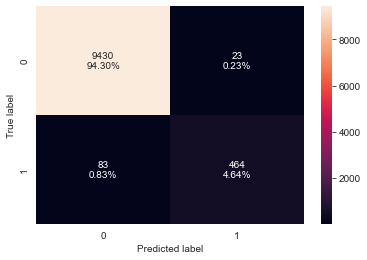

In [41]:
rf_model.fit(X_train_over, y_train_over)
y_pred_rf = rf_model.predict(X_test)

print("##### Random Forest Classifier Oversampled Data Result #####")
print(model_performance_classification_sklearn(rf_model, X_test, y_test))
confusion_matrix_sklearn(rf_model, X_test, y_test)


print("\n##### Cross Validation Result #####")
cv_result_rfo = cross_val_score(rf_model, X_train_over, y_train_over, cv=kfold, scoring='roc_auc')
print(cv_result_rfo)

### AdaBoost Classifier

##### Adaboost Classifier Oversampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0     0.904  0.837294    0.34462  0.488273               0.554954

##### Cross Validation Result #####
[0.95086155 0.95143585]


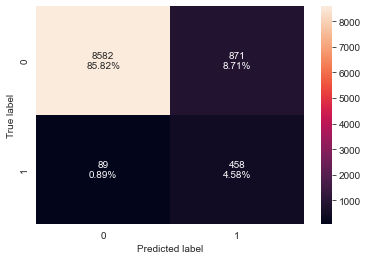

In [42]:
ada_classifier.fit(X_train_over, y_train_over)
y_pred_ada = ada_classifier.predict(X_test)

print("##### Adaboost Classifier Oversampled Data Result #####")
print(model_performance_classification_sklearn(ada_classifier, X_test, y_test))
confusion_matrix_sklearn(ada_classifier, X_test, y_test)


print("\n##### Cross Validation Result #####")
cv_result_abo = cross_val_score(ada_classifier, X_train_over, y_train_over, cv=kfold, scoring='roc_auc')
print(cv_result_abo)

### KNN Classifier

##### KNN Classifier Oversampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9579  0.864717   0.576829  0.692026               0.695929

##### Cross Validation Result #####
[0.99452297 0.99586208]


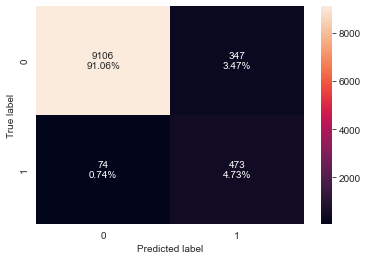

In [43]:
knn_classifier.fit(X_train_over, y_train_over)
y_pred_knn = knn_classifier.predict(X_test)

print("##### KNN Classifier Oversampled Data Result #####")
print(model_performance_classification_sklearn(knn_classifier, X_test, y_test))
confusion_matrix_sklearn(knn_classifier, X_test, y_test)


print("\n##### Cross Validation Result #####")
cv_result_knno = cross_val_score(knn_classifier, X_train_over, y_train_over, cv=kfold, scoring='roc_auc')
print(cv_result_knno)

### XGBoost Classifier

[18:47:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
##### XGBoost Classifier Oversampled Data Result #####
   Accuracy    Recall  Precision       F1  Minimum_Vs_Model_cost
0    0.9869  0.870201    0.88806  0.87904               0.798152

##### Cross Validation Result #####
[18:47:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric

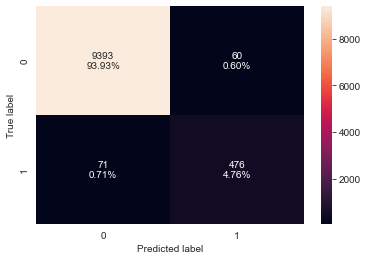

In [44]:
xgb_classifier.fit(X_train_over, y_train_over)
y_pred_xgb = xgb_classifier.predict(X_test)

print("##### XGBoost Classifier Oversampled Data Result #####")
print(model_performance_classification_sklearn(xgb_classifier, X_test, y_test))
confusion_matrix_sklearn(xgb_classifier, X_test, y_test)


print("\n##### Cross Validation Result #####")
cv_result_xgbo = cross_val_score(xgb_classifier, X_train_over, y_train_over, cv=kfold, scoring='roc_auc')
print(cv_result_xgbo)

### Result


In [45]:
print("## Testing with Oversampled Data ##\n")
print("Cross-Validation Performance:")
print("Logistic Regression: ", cv_result_lro.mean())
print("Decision Tree: ", cv_result_dto.mean())
print("Random Forest: ", cv_result_rfo.mean())
print("AdaBoost Classifier: ", cv_result_abo.mean())
print("KNN Classifier: ", cv_result_knno.mean())
print("XGBoost Classifier: ", cv_result_xgbo.mean())

print("\n \nTraining Performance:")
print("Logistic Regression: ", Minimum_Vs_Model_cost(log_reg, X_test, y_test))
print("Decision Tree: ", Minimum_Vs_Model_cost(dec_clf, X_test, y_test))
print("Random Forest: ", Minimum_Vs_Model_cost(rf_model, X_test, y_test))
print("AdaBoost Classifier: ", Minimum_Vs_Model_cost(ada_classifier, X_test, y_test))
print("KNN Classifier: ", Minimum_Vs_Model_cost(knn_classifier, X_test, y_test))
print("XGBoost Classifier: ", Minimum_Vs_Model_cost(xgb_classifier, X_test, y_test))

## Testing with Oversampled Data ##

Cross-Validation Performance:
Logistic Regression:  0.9276250888687632
Decision Tree:  0.9513658355297359
Random Forest:  0.9985126105937192
AdaBoost Classifier:  0.9511486984292663
KNN Classifier:  0.9951925260895831
XGBoost Classifier:  0.9985606059228476

 
Training Performance:
Logistic Regression:  0.49353383458646616
Decision Tree:  0.6284948295672156
Random Forest:  0.7893217893217893
AdaBoost Classifier:  0.5549543456205613
KNN Classifier:  0.6959287531806616
XGBoost Classifier:  0.7981517509727627


## Model Building with Undersampled data

In [46]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [47]:
print("Original Data Size")
print(X_train.shape)
print(y_train.shape)
print("Oversampled Data Size")
print(X_train_un.shape)
print(y_train_un.shape)

Original Data Size
(40000, 40)
(40000,)
Oversampled Data Size
(4374, 40)
(4374,)


### Logistic Regression

##### Logistic Regression Undersampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.8592  0.826325   0.256091  0.391003               0.478565

##### Cross Validation Result #####
[0.91316065 0.92764865]


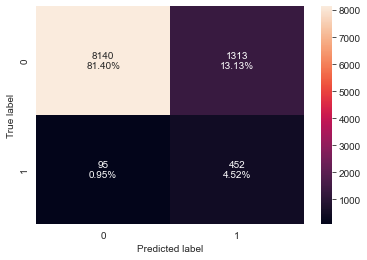

In [48]:
log_reg.fit(X_train_un, y_train_un)
y_pred_lr = log_reg.predict(X_test)

print("##### Logistic Regression Undersampled Data Result #####")
print(model_performance_classification_sklearn(log_reg, X_test, y_test))
confusion_matrix_sklearn(log_reg, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_lru = cross_val_score(log_reg, X_train_un, y_train_un, cv=kfold, scoring='roc_auc')
print(cv_result_lru)

### Decision Tree Classifier

##### Decision Tree Classifier Undersampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.8522  0.848263   0.249597  0.385702               0.475514

##### Cross Validation Result #####
[0.85710317 0.85419808]


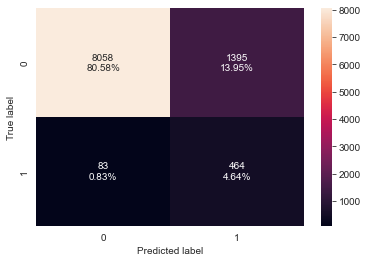

In [49]:
dec_clf.fit(X_train_un, y_train_un)
y_pred_dt = dec_clf.predict(X_test)

print("##### Decision Tree Classifier Undersampled Data Result #####")
print(model_performance_classification_sklearn(dec_clf, X_test, y_test))
confusion_matrix_sklearn(dec_clf, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_dtu = cross_val_score(dec_clf, X_train_un, y_train_un, cv=kfold, scoring='roc_auc')
print(cv_result_dtu)

### Random Forest Classifier

##### Random Forest Classifier Undersampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9634  0.888483   0.614412  0.726457               0.729009

##### Cross Validation Result #####
[0.96103618 0.94971924]


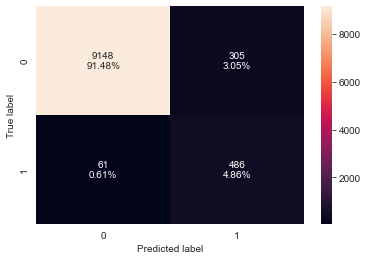

In [50]:
rf_model.fit(X_train_un, y_train_un)
y_pred_rf = rf_model.predict(X_test)

print("##### Random Forest Classifier Undersampled Data Result #####")
print(model_performance_classification_sklearn(rf_model, X_test, y_test))
confusion_matrix_sklearn(rf_model, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_rfu = cross_val_score(rf_model, X_train_un, y_train_un, cv=kfold, scoring='roc_auc')
print(cv_result_rfu)

### Adaboost Classifier

##### Adaboost Classifier Undersampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.8901  0.857404   0.314765  0.460481                0.53768

##### Cross Validation Result #####
[0.92971041 0.93475658]


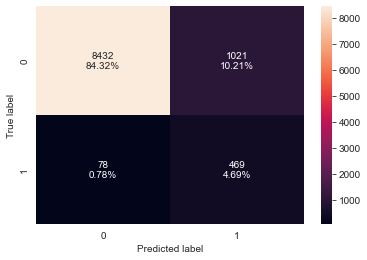

In [51]:
ada_classifier.fit(X_train_un, y_train_un)
y_pred_ada = ada_classifier.predict(X_test)

print("##### Adaboost Classifier Undersampled Data Result #####")
print(model_performance_classification_sklearn(ada_classifier, X_test, y_test))
confusion_matrix_sklearn(ada_classifier, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_abu = cross_val_score(ada_classifier, X_train_un, y_train_un, cv=kfold, scoring='roc_auc')
print(cv_result_abu)

### KNN Classifier

##### KNN Classifier Undersampled Data Result #####
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9691  0.88117   0.663912  0.757266               0.742534

##### Cross Validation Result #####
[0.95517017 0.94767978]


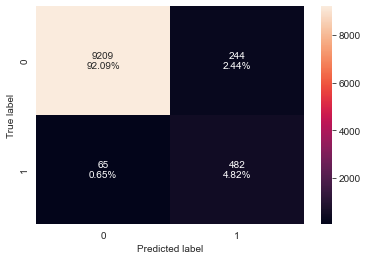

In [52]:
knn_classifier.fit(X_train_un, y_train_un)
y_pred_knn = knn_classifier.predict(X_test)

print("##### KNN Classifier Undersampled Data Result #####")
print(model_performance_classification_sklearn(knn_classifier, X_test, y_test))
confusion_matrix_sklearn(knn_classifier, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_knnu = cross_val_score(knn_classifier, X_train_un, y_train_un, cv=kfold, scoring='roc_auc')
print(cv_result_knnu)

### XGBoost Classifier

[18:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
##### XGBoost Classifier Undersampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9649  0.890311   0.625964  0.735094               0.735215

##### Cross Validation Result #####
[18:49:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation met

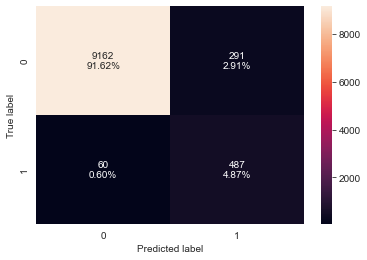

In [53]:
xgb_classifier.fit(X_train_un, y_train_un)
y_pred_xgb = xgb_classifier.predict(X_test)

print("##### XGBoost Classifier Undersampled Data Result #####")
print(model_performance_classification_sklearn(xgb_classifier, X_test, y_test))
confusion_matrix_sklearn(xgb_classifier, X_test, y_test)

print("\n##### Cross Validation Result #####")
cv_result_xgbu = cross_val_score(xgb_classifier, X_train_un, y_train_un, cv=kfold, scoring='roc_auc')
print(cv_result_xgbu)

### Result

In [54]:
print("## Testing with Undersampled Data ##\n")
print("Cross-Validation Performance:")
print("Logistic Regression: ", cv_result_lru.mean())
print("Decision Tree: ", cv_result_dtu.mean())
print("Random Forest: ", cv_result_rfu.mean())
print("AdaBoost Classifier: ", cv_result_abu.mean())
print("KNN Classifier: ", cv_result_knnu.mean())
print("XGBoost Classifier: ", cv_result_xgbu.mean())

print("\n \nTraining Performance:")
print("Logistic Regression: ", Minimum_Vs_Model_cost(log_reg, X_test, y_test))
print("Decision Tree: ", Minimum_Vs_Model_cost(dec_clf, X_test, y_test))
print("Random Forest: ", Minimum_Vs_Model_cost(rf_model, X_test, y_test))
print("AdaBoost Classifier: ", Minimum_Vs_Model_cost(ada_classifier, X_test, y_test))
print("KNN Classifier: ", Minimum_Vs_Model_cost(knn_classifier, X_test, y_test))
print("XGBoost Classifier: ", Minimum_Vs_Model_cost(xgb_classifier, X_test, y_test))

## Testing with Undersampled Data ##

Cross-Validation Performance:
Logistic Regression:  0.9204046470002759
Decision Tree:  0.8556506256160357
Random Forest:  0.9553777078597558
AdaBoost Classifier:  0.9322334991408461
KNN Classifier:  0.9514249723135809
XGBoost Classifier:  0.9543949151124864

 
Training Performance:
Logistic Regression:  0.4785651793525809
Decision Tree:  0.47551434366850187
Random Forest:  0.729009329187028
AdaBoost Classifier:  0.5376802096985583
KNN Classifier:  0.7425339366515837
XGBoost Classifier:  0.7352150537634409


## Model Selection

The best performing models are:
- XGBoost model with Oversampled data with a Minimum_Vs_Model_cost of 0.798
- Random Forest with Oversampled data with a Minimum_Vs_Model_cost of 0.789
- XGBoost model with Original data with a Minimum_Vs_Model_cost of 0.774
- KNN model with Undersampled Data with a Minimum_Vs_Model_cost of 0.742

Thus, I have selected to tune XGBoost, Random Forest and KNN models to further improve the results.

## HyperparameterTuning 

### Random Forest Classifier

In [57]:
# Hyper Parameters selected for Random Forest

param_rf = { 
    "n_estimators": [300, 600, 900], 
    "min_samples_leaf": [1, 2, 3], 
    "max_features": ['sqrt', 'log2'], 
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

In [58]:
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_rf, cv=5)
random_search_rf.fit(X_train_over, y_train_over)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'n_estimators': [300, 600, 900]})

In [66]:
random_search_rf.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features='sqrt', n_estimators=900)

In [67]:
random_search_rf.cv_results_['params']

[{'n_estimators': 900,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'criterion': 'entropy',
  'bootstrap': False},
 {'n_estimators': 900,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'criterion': 'gini',
  'bootstrap': False},
 {'n_estimators': 300,
  'min_samples_leaf': 3,
  'max_features': 'log2',
  'criterion': 'gini',
  'bootstrap': True},
 {'n_estimators': 900,
  'min_samples_leaf': 3,
  'max_features': 'sqrt',
  'criterion': 'entropy',
  'bootstrap': False},
 {'n_estimators': 600,
  'min_samples_leaf': 3,
  'max_features': 'sqrt',
  'criterion': 'gini',
  'bootstrap': False},
 {'n_estimators': 300,
  'min_samples_leaf': 3,
  'max_features': 'sqrt',
  'criterion': 'gini',
  'bootstrap': False},
 {'n_estimators': 900,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'criterion': 'gini',
  'bootstrap': False},
 {'n_estimators': 600,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'criterion': 'gini',
  'bootstrap': True},
 {'n_estimators': 300,
  'min_sample

In [68]:
random_search_rf.cv_results_['mean_test_score']

array([0.99307116, 0.99192075, 0.98590431, 0.99155052, 0.98985797,
       0.98995053, 0.99188109, 0.98831089, 0.9882051 , 0.9921191 ])

In [69]:
# Use these best parametres for final Random Forest model
random_search_rf.best_params_

{'n_estimators': 900,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'criterion': 'entropy',
 'bootstrap': False}

##### Random Forest Classifier Hyper Tuned Result #####
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9902  0.85192   0.964803  0.904854               0.795444


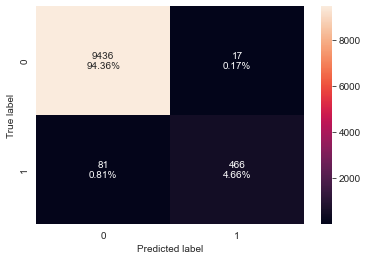

In [70]:
rf_hypertuned = RandomForestClassifier(bootstrap=False, n_estimators=900, 
                                       min_samples_leaf=1, max_features='sqrt', criterion='entropy')
rf_hypertuned.fit(X_train_over, y_train_over)
y_pred_rf = rf_hypertuned.predict(X_test)

print("##### Random Forest Classifier Hyper Tuned Result #####")
print(model_performance_classification_sklearn(rf_hypertuned, X_test, y_test))
confusion_matrix_sklearn(rf_hypertuned, X_test, y_test)

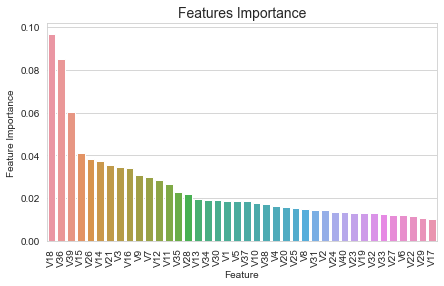

In [71]:
tmp = pd.DataFrame({'Feature': columns, 'Feature Importance': rf_hypertuned.feature_importances_})
tmp = tmp.sort_values(by='Feature Importance', ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features Importance', fontsize=14)
s = sns.barplot(x='Feature', y='Feature Importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

### KNN Classifier

In [72]:
# Hyper Parameters selected for KNN

param_knn = { 
    "leaf_size": [1, 2, 3],
    "n_neighbors": [1, 5, 10], 
    "p": [1, 2, 3]
}

In [73]:
grid_search = GridSearchCV(knn_classifier, param_knn, cv=5)
grid_search.fit(X_train_un, y_train_un)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3], 'n_neighbors': [1, 5, 10],
                         'p': [1, 2, 3]})

In [74]:
grid_search.best_estimator_

KNeighborsClassifier(leaf_size=1)

In [75]:
grid_search.cv_results_['params']

[{'leaf_size': 1, 'n_neighbors': 1, 'p': 1},
 {'leaf_size': 1, 'n_neighbors': 1, 'p': 2},
 {'leaf_size': 1, 'n_neighbors': 1, 'p': 3},
 {'leaf_size': 1, 'n_neighbors': 5, 'p': 1},
 {'leaf_size': 1, 'n_neighbors': 5, 'p': 2},
 {'leaf_size': 1, 'n_neighbors': 5, 'p': 3},
 {'leaf_size': 1, 'n_neighbors': 10, 'p': 1},
 {'leaf_size': 1, 'n_neighbors': 10, 'p': 2},
 {'leaf_size': 1, 'n_neighbors': 10, 'p': 3},
 {'leaf_size': 2, 'n_neighbors': 1, 'p': 1},
 {'leaf_size': 2, 'n_neighbors': 1, 'p': 2},
 {'leaf_size': 2, 'n_neighbors': 1, 'p': 3},
 {'leaf_size': 2, 'n_neighbors': 5, 'p': 1},
 {'leaf_size': 2, 'n_neighbors': 5, 'p': 2},
 {'leaf_size': 2, 'n_neighbors': 5, 'p': 3},
 {'leaf_size': 2, 'n_neighbors': 10, 'p': 1},
 {'leaf_size': 2, 'n_neighbors': 10, 'p': 2},
 {'leaf_size': 2, 'n_neighbors': 10, 'p': 3},
 {'leaf_size': 3, 'n_neighbors': 1, 'p': 1},
 {'leaf_size': 3, 'n_neighbors': 1, 'p': 2},
 {'leaf_size': 3, 'n_neighbors': 1, 'p': 3},
 {'leaf_size': 3, 'n_neighbors': 5, 'p': 1},
 {'l

In [76]:
grid_search.cv_results_['mean_test_score']

array([0.9067201 , 0.90397646, 0.90397646, 0.93758588, 0.93872926,
       0.93575704, 0.93621419, 0.93804302, 0.93621393, 0.9067201 ,
       0.90397646, 0.90397646, 0.93758588, 0.93872926, 0.93575704,
       0.93621419, 0.93804302, 0.93621393, 0.9067201 , 0.90397646,
       0.90397646, 0.93758588, 0.93872926, 0.93575704, 0.93621419,
       0.93804302, 0.93621393])

In [78]:
# Use these best parametres for final KNN model
grid_search.best_params_

{'leaf_size': 1, 'n_neighbors': 5, 'p': 2}

##### KNN Classifier Hyper Tuned Result #####
   Accuracy   Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9691  0.88117   0.663912  0.757266               0.742534


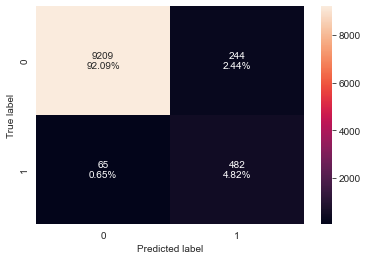

In [79]:
knn_hypertuned=KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=5)
knn_hypertuned.fit(X_train_un, y_train_un)
y_pred_knn = knn_hypertuned.predict(X_test)

print("##### KNN Classifier Hyper Tuned Result #####")
print(model_performance_classification_sklearn(knn_hypertuned, X_test, y_test))
confusion_matrix_sklearn(knn_hypertuned, X_test, y_test)

### XGBoost Classifier

In [81]:
# Hyper Parameters selected for XGBoost

params_xgb = {
 "learning_rate"    : [0.01, 0.10, 0.15, 0.20, 0.25],
 "max_depth"        : [10, 15, 20, 25, 30],
 "min_child_weight" : [1, 2, 3],
 "gamma"            : [0.1, 0.3, 0.4, 0.5],
 "eval_metric"      : ['auc', 'logloss'],
 "colsample_bytree" : [0.5, 0.7, 0.9]
}

In [82]:
xgb_classifier = xgboost.XGBClassifier()
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=params_xgb, n_iter=5, scoring='roc_auc', cv=5)
random_search.fit(X_train_over, y_train_over)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [83]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='logloss', gamma=0.5,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=30,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=28, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [84]:
random_search.cv_results_['params']

[{'min_child_weight': 3,
  'max_depth': 20,
  'learning_rate': 0.1,
  'gamma': 0.3,
  'eval_metric': 'auc',
  'colsample_bytree': 0.7},
 {'min_child_weight': 2,
  'max_depth': 10,
  'learning_rate': 0.2,
  'gamma': 0.5,
  'eval_metric': 'logloss',
  'colsample_bytree': 0.7},
 {'min_child_weight': 1,
  'max_depth': 20,
  'learning_rate': 0.2,
  'gamma': 0.5,
  'eval_metric': 'auc',
  'colsample_bytree': 0.7},
 {'min_child_weight': 2,
  'max_depth': 30,
  'learning_rate': 0.2,
  'gamma': 0.5,
  'eval_metric': 'logloss',
  'colsample_bytree': 0.5},
 {'min_child_weight': 3,
  'max_depth': 25,
  'learning_rate': 0.01,
  'gamma': 0.4,
  'eval_metric': 'logloss',
  'colsample_bytree': 0.9}]

In [85]:
random_search.cv_results_['mean_test_score']

array([0.99946447, 0.99944406, 0.99944958, 0.99947955, 0.99787092])

In [86]:
# Use these best parametres for final XGBoost model
random_search.best_params_

{'min_child_weight': 2,
 'max_depth': 30,
 'learning_rate': 0.2,
 'gamma': 0.5,
 'eval_metric': 'logloss',
 'colsample_bytree': 0.5}

##### XGBoost Classifier Hyper Tuned Result #####
   Accuracy    Recall  Precision       F1  Minimum_Vs_Model_cost
0    0.9895  0.872029   0.931641  0.90085                0.80997


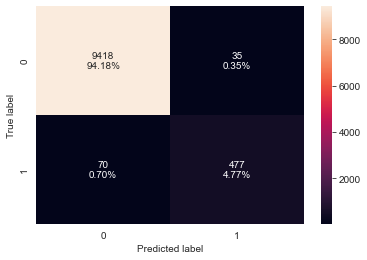

In [90]:
xgb_hypertuned = xgboost.XGBClassifier(colsample_bytree=0.5,
              eval_metric='logloss', gamma=0.5,
              learning_rate=0.2, max_depth=30,
              min_child_weight=2)
xgb_hypertuned.fit(X_train_over, y_train_over)
y_pred_xgb = xgb_hypertuned.predict(X_test)

print("##### XGBoost Classifier Hyper Tuned Result #####")
print(model_performance_classification_sklearn(xgb_hypertuned, X_test, y_test))
confusion_matrix_sklearn(xgb_hypertuned, X_test, y_test)

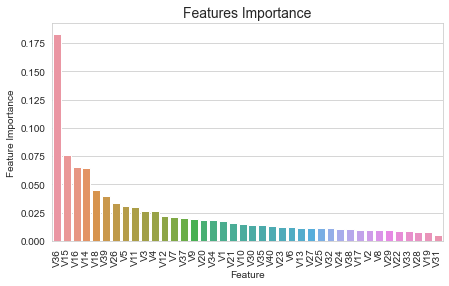

In [91]:
tmp = pd.DataFrame({'Feature': columns, 'Feature Importance': xgb_hypertuned.feature_importances_})
tmp = tmp.sort_values(by='Feature Importance', ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features Importance', fontsize=14)
s = sns.barplot(x='Feature', y='Feature Importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

## Model Performance comparison and choosing the final model

In [92]:
print("## Testing with Hyper Parameterized Models ##\n")
print("Cross-Validation Performance:")
print("Random Forest: ", random_search_rf.cv_results_['mean_test_score'].mean())
print("KNN Classifier: ", grid_search.cv_results_['mean_test_score'].mean())
print("XGBoost Classifier: ", random_search.cv_results_['mean_test_score'].mean())

print("\n \nTraining Performance:")
print("Random Forest: ", Minimum_Vs_Model_cost(rf_hypertuned, X_test, y_test))
print("KNN Classifier: ", Minimum_Vs_Model_cost(knn_hypertuned, X_test, y_test))
print("XGBoost Classifier: ", Minimum_Vs_Model_cost(xgb_hypertuned, X_test, y_test))

## Testing with Hyper Parameterized Models ##

Cross-Validation Performance:
Random Forest:  0.9902771423732112
KNN Classifier:  0.9263573716900946
XGBoost Classifier:  0.9991417170507578

 
Training Performance:
Random Forest:  0.7954435288414929
KNN Classifier:  0.7425339366515837
XGBoost Classifier:  0.8099703849950641


#### Result:
- Based on the model results from these hyper tuned models, XGBoost Classifier is working best among all models.
- Thus based on highest Minimum_Vs_Model_cost ratio, XGBoost with Oversampled data is my final model.

## Test set final performance

##### Hyper Tuned XGBoost Classifier with Oversampled Data Result #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9893  0.873857   0.926357  0.899341               0.810771


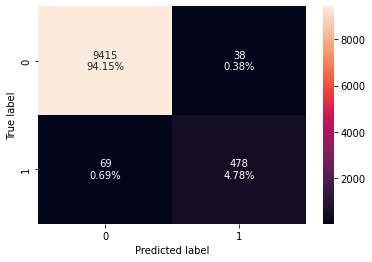

In [32]:
print("##### Hyper Tuned XGBoost Classifier with Oversampled Data Result #####")
print(model_performance_classification_sklearn(xgb_hypertuned, X_test, y_test))
confusion_matrix_sklearn(xgb_hypertuned, X_test, y_test)

- XGBoost with oversampled data works best with Minimum_Vs_Model_cost of 0.810771.

## Pipelines to build the final model


In [93]:
numerical_transformer = SimpleImputer(strategy='constant')
numerical_cols = [cname for cname in X_train_over.columns if X_train_over[cname].dtype in ['int64', 'float64']]
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols)])
preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
                                  'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
                                  'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                                  'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
                                  'V27', 'V28', 'V29', 'V30', ...])])

In [94]:
# Create initial pipeline for XGBoost model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', xgboost.XGBClassifier())])

In [107]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:

params_xgb = {
 "model__learning_rate"    : [0.01, 0.10, 0.20],
 "model__max_depth"        : [20, 25, 30],
 "model__gamma"            : [0.4, 0.5],
 "model__eval_metric"      : ['auc', 'logloss'],
 "model__colsample_bytree" : [0.5, 0.7]
}

In [108]:
# Perform Grid Search using the pipeline

grid_search_pipe = GridSearchCV(pipeline, params_xgb, cv=5, scoring='roc_auc')
grid_search_pipe.fit(X_train_over, y_train_over)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['V1',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V5',
                                                                          'V6',
                                                                          'V7',
                                                                          'V8',
                                                                          'V9',
                

In [109]:
grid_search_pipe.best_params_

{'model__colsample_bytree': 0.5,
 'model__eval_metric': 'auc',
 'model__gamma': 0.4,
 'model__learning_rate': 0.1,
 'model__max_depth': 30}

In [120]:
# Create final hyperparameter optimized pipeline for XGBoost model

model = xgboost.XGBClassifier(colsample_bytree=0.5,
              eval_metric='auc', gamma=0.4,
              learning_rate=0.1, max_depth=30)
final_pipeline_model = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])

In [121]:
final_pipeline_model.fit(X_train_over, y_train_over)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28', 'V29',
                                                   'V30', ...])])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsampl...
                               eval_metric='auc', gamma=0.4, gpu_id=-1,

In [122]:
y_pred = final_pipeline_model.predict(X_test)

##### Pipelined Model Results #####
   Accuracy    Recall  Precision        F1  Minimum_Vs_Model_cost
0    0.9891  0.870201    0.92607  0.897267               0.806785


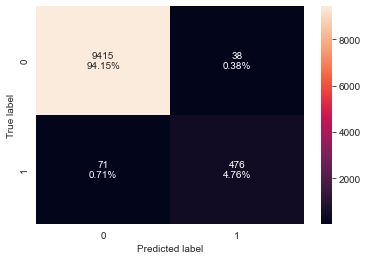

In [123]:
print("##### Pipelined Model Results #####")
print(model_performance_classification_sklearn(final_pipeline_model, X_test, y_test))
confusion_matrix_sklearn(final_pipeline_model, X_test, y_test)

In [124]:
# Timing ends here for "track_time" variable
timer(track_time)


 Time taken to run this notebook: 16 hours 48 minutes and 43.25 seconds.
